### Betfair Historical Data demonstration and testing
1. Demonstrating how to download and open data from the Betfair Historical Data service.
2. Adding some useful variables for the purposes of data analysis
3. Using `matplotlib` to visualise price and volume data for a given horse.


To connect to the Betfair API through betfairlightweight, you must have first set up your API certificates and saved the login details in dictionary format in a file called `api_logins.json` in the project home directory (`/betfair_project`). The following connects and should return `<LoginResource>` if successful.

In [1]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
from pathlib import Path, PurePath #To define open and save locations that are cross-compatible between Windows/Linux
from bz2 import BZ2File #To unzip the Betfair data from its downloaded format
import matplotlib.pyplot as plt

project_dir = Path.cwd().parents[1]
logins_dir = project_dir / 'api_logins.json'

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

To perform the following, you must have purchased data from the [Betfair Historical data service](https://historicdata.betfair.com/#/home). Advanced data for all sports has been offered for free for Jan - May 2020. To understand more about what different packages of data include, look in the data dictionaries folder in this project.

The following lists the data that you have purchased on your Betfair account. Since data is purchased by month, that is how it is represented here:

In [2]:
my_data = trading.historic.get_my_data()
for i in my_data:
    print(i)

{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-01-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-02-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-03-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41549}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41549}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2016-01-01T00:00:00', 'purchaseItemId': 25202}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2017-06-01T00:00:00', 'purchaseItemId': 770}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2018-01-01T00:00:00', 'purchaseItemId': 24527}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2018-02-01T00:00:00', 'purchaseItemId': 24527}
{'sport': 'Horse Racing'

For our purposes, we will want to select relatively small subset of the data available from the months of data above. The following selects just the data for from 01/01/20 to 01/03/20 and returns a dictionary of the contents of the data which we go on to use to download specific country/race/market types, and tells us the size of the entire selection:

In [4]:
collection_options = trading.historic.get_collection_options(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)

print(collection_options)

basket_size = trading.historic.get_data_size(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)
print(basket_size)

{'marketTypesCollection': [{'name': '', 'count': 1998}, {'name': 'ANTEPOST_WIN', 'count': 22}, {'name': 'DAILY_WIN_DIST', 'count': 1}, {'name': 'EACH_WAY', 'count': 1788}, {'name': 'FORECAST', 'count': 438}, {'name': 'MATCH_BET', 'count': 1692}, {'name': 'OTHER_PLACE', 'count': 4746}, {'name': 'PLACE', 'count': 9161}, {'name': 'RACE_WIN_DIST', 'count': 175}, {'name': 'REV_FORECAST', 'count': 784}, {'name': 'WIN', 'count': 11923}, {'name': 'WITHOUT_FAV', 'count': 306}], 'countriesCollection': [{'name': 'AE', 'count': 511}, {'name': 'AU', 'count': 11874}, {'name': 'ES', 'count': 6}, {'name': 'FR', 'count': 549}, {'name': 'GB', 'count': 10230}, {'name': 'HK', 'count': 1}, {'name': 'IE', 'count': 2147}, {'name': 'NZ', 'count': 2016}, {'name': 'SA', 'count': 44}, {'name': 'SG', 'count': 314}, {'name': 'US', 'count': 4038}, {'name': 'ZA', 'count': 1304}], 'fileTypeCollection': [{'name': 'E', 'count': 1998}, {'name': 'M', 'count': 31036}]}
{'totalSizeMB': 5731, 'fileCount': 33034}


To dig into particular dates, countries, race types and market types we use `.get_file_list()`, specifying our filtering parameters. For example, you can see above that within the sub-dictionary for `'marketTypesCollection'` we have `'WIN'`, among others. 

The following retrieves a list of the event files that match these parameters. We select only data for 01/02/20, for the `'WIN'` market only and in `'GB'`.

In [5]:
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Advanced Plan",
    from_day=1,
    from_month=2,
    from_year=2020,
    to_day=1,
    to_month=2,
    to_year=2020,
    market_types_collection=["WIN"],
    countries_collection=["GB"],
    file_type_collection=["M"]\
    ,
)
print(file_list)

['/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130661.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136214.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133543.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130666.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096559.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136219.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130671.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133548.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096566.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136224.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133553.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130676.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168130245.bz2', '/xds

To downoad a file, `download_file()` is used, where we specify the download location (on Betfair) in `file_path` and the directory to which it is saved in `store_directory`. The filename is kept as is from Betfair. We both download the file and use the command to assign the file's location to the variable `download` so we can use it in subsequent operations.

`file_path` can be a list input, however, only the second file within that list is downloaded below.

In [6]:
data_dir = project_dir / 'data' / 'raw' / 'api'
file = file_list[1]
print(file)
download = trading.historic.download_file(file_path = file, store_directory = data_dir)
print(download)

/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2
/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168096552.bz2


The downloaded file is .json formatted compressed in a bzip2 (.bz2) folder. The following extracts the file where it is downloaded. It is given no file extension, however it remains in .txt format and is readable in any text reader.

In [7]:
filename = str(download)
zipfile = BZ2File(filename) # open the file
data = zipfile.read() # get the decompressed data
newfilepath = filename[:-4] # assuming the filepath ends with .bz2, removing the extension and saving without a filetype
open(newfilepath, 'wb').write(data) # write an uncompressed file
zipfile.close()

## Using stream listener to read extracted data

We now have a readable raw text file in Betfair's dictionary format. To interpret the data with python, betfairlightweight includes a stream listener which will interpret the input of historical data in the same way that it does for live data. The below is edited from [here](https://github.com/liampauling/betfair/blob/104ff4cb8734038cb9351e74d16dc7bd018111bc/examples/examplestreaminghistorical.py). 

This finds the chosen variables in the data file and outputs them in a .csv format in output.txt. Note: output.txt is ignored by git and is not uploaded into the repository.

In [21]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)
        with open("output.txt", "w") as output:
            output.write("Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,\
            AdjFactor,Handicap,RunnerStatus,MktBetDelay,BspReconciled,RaceComplete,CrossMatching,\
            DataDelayed,NumRunnersActive,NumRunners,NumWinners,RunnersVoidable,MktTotalMatched\n")

    def on_process(self, market_books):
        with open("output.txt", "a") as output:
            for market_book in market_books:
                for runner in market_book.runners:
                    print(runner.ex.available_to_back[0])

                        
                    

class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

stream = trading.streaming.create_historical_stream(
    directory=newfilepath,
    listener=listener,
)

stream.start() #This fills output.txt, after all the above defines its contents

Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.55 Size: 18.18
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.57 Size: 1.99
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.56 Size: 10
Price: 1.57 Size: 1.99
Price: 1.56 Size: 10
Price: 1.57 Size: 1.99
P

Price: 3 Size: 1
Price: 2.1 Size: 1.99
Price: 2.1 Size: 1.99
Price: 2.1 Size: 1.99
Price: 2.1 Size: 1.99
Price: 2.1 Size: 1.99
Price: 3 Size: 1
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 3 Size: 1
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 2.12 Size: 2.06
Price: 3 Size: 1
Price: 2.12 Size: 2.06
Price: 2.14 Size: 1.99
Price: 2.12 Size: 2.06
Price: 2.14 Size: 1.99
Price: 2.12 Size: 2.06
Price: 3 Size: 1
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 3 Size: 1
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 2.14 Size: 1.99
Price: 3 Size: 1
Price: 2.14 Size: 1.99
Price: 2.16 Size: 1.68
Price: 2.14 Size: 1.99
Price: 2.16 Size: 1.68
Price: 2.14 Size: 1.99
Price: 3 Size: 1
Price: 2.16 Size: 1.68
Price: 2.16 Size: 1.68
Price: 2.16 Size: 

Price: 3.05 Size: 2.22
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.76 Size: 11.86
Price: 2.84 Size: 1.68
Price: 2.76 Size: 11.86
Price: 3.05 Size: 2.22
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.84 Size: 1.68
Price: 2.76 Size: 2.59
Price: 3.05 Size: 2.22
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.84 Size: 1.68
Price: 2.76 Size: 2.59
Price: 3.05 Size: 2.22
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.76 Size: 2.59
Price: 2.58 Size: 1.68
Price: 2.76 Size: 2.59
Price: 3.05 Size: 2.22
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.58 Size: 1.68
Price: 2.76 Size: 2.59
Price: 3.05 Size: 2.22
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.58 Size: 1.68
Price: 2.78 Size: 2.97
Price: 3.05 Size: 2.22
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.78 Size: 2.97
Price: 2.58 Size: 1.68
Price: 2.78 Size: 2.97
Price: 3.05 Size: 2.22
Price: 2.

Price: 3.05 Size: 6.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 5.48
Price: 4.4 Size: 1.99
Price: 3 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 5.48
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 6.17
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 6.17
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 6.17
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 6.17
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.6 Size: 1.99
Price: 4 Size: 1.99
Price: 2.36 Size: 6.17
Price: 4.4 Size: 1.99
Price: 2.88 Size: 3.28
Price: 4.4 Size: 1.99
Price: 3.65 Size: 1.68
Price: 4 Si

Price: 2.78 Size: 3
Price: 9.4 Size: 1.99
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.52 Size: 18.97
Price: 7 Size: 1.99
Price: 2.78 Size: 3
Price: 9.4 Size: 1.99
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.52 Size: 19.62
Price: 7 Size: 1.99
Price: 2.78 Size: 3
Price: 9.4 Size: 1.99
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.52 Size: 19.62
Price: 7 Size: 1.99
Price: 2.78 Size: 3
Price: 9.4 Size: 1.99
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.52 Size: 19.62
Price: 7 Size: 1.99
Price: 2.78 Size: 5.97
Price: 9.6 Size: 1.98
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.54 Size: 3.44
Price: 7.2 Size: 1.98
Price: 2.8 Size: 3
Price: 9.6 Size: 1.98
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.54 Size: 3.44
Price: 7.2 Size: 1.98
Price: 2.8 Size: 3
Price: 9.6 Size: 1.98
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.54 Size: 3.44
Price: 7.2 Size: 1.98
Price: 2.82 Size: 2.11
Price: 9.6 Size: 1.98
Price: 4 Size: 16.02
Price: 6 Size: 1.06
Price: 2.54 Size: 3.4

Price: 3.05 Size: 5.14
Price: 9.8 Size: 1.98
Price: 4.1 Size: 6.26
Price: 18 Size: 1.16
Price: 2.72 Size: 9.84
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 1.98
Price: 4.1 Size: 6.26
Price: 18 Size: 1.16
Price: 2.72 Size: 9.84
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 1.98
Price: 4.1 Size: 6.26
Price: 18 Size: 3.14
Price: 2.72 Size: 12.63
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 4.02
Price: 4.1 Size: 6.26
Price: 18.5 Size: 1.08
Price: 2.74 Size: 7.76
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 4.02
Price: 4.1 Size: 6.26
Price: 18.5 Size: 1.08
Price: 2.76 Size: 7.59
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 4.02
Price: 4.1 Size: 6.26
Price: 18.5 Size: 1.08
Price: 2.76 Size: 8.05
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 4.02
Price: 4.1 Size: 6.26
Price: 18.5 Size: 1.08
Price: 2.76 Size: 8.05
Price: 34 Size: 1.18
Price: 3.05 Size: 5.14
Price: 9.8 Size: 4.02
Price: 4.1 Size: 6.26


Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 4.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 4.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 4.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 1.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 1.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4.1 Size: 1.98
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4 Size: 46.37
Price: 21 Size: 2.89
Price: 2.98 Size: 4.65
Price: 34 Size: 1.5
Price: 3.25 Size: 5.37
Price: 10.5 Size: 1.16
Price: 4 Size: 43.37
Price: 21 

Price: 3.25 Size: 4.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.8 Size: 5.88
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.8 Size: 5.88
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.82 Size: 5.12
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.82 Size: 8.48
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.82 Size: 8.48
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.84 Size: 5.88
Price: 34 Size: 1.5
Price: 3.25 Size: 10.15
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2
Price: 2.84 Size: 5.88
Price: 34 Size: 1.5
Price: 3.25 Size: 9.36
Price: 10.5 Size: 1.16
Price: 4.6 Size: 20.46
Price: 26 Size: 2

Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.78 Size: 10.91
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size: 3.14
Price: 4.6 Size: 9.34
Price: 29 Size: 3.98
Price: 2.76 Size: 26.68
Price: 13.5 Size: 1.98
Price: 3.15 Size: 20.63
Price: 10.5 Size:

Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.7 Size: 52.03
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.72 Size: 3
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.64 Size: 18.93
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.66 Size: 2.84
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.66 Size: 2.84
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.66 Size: 9.56
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 1.98
Price: 2.66 Size: 9.56
Price: 14.5 Size: 8.32
Price: 3.15 Size: 1.03
Price: 9.8 Size: 2.98
Price: 4.8 Size: 1
Price: 32 Size: 2.52


Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 7.43
Price: 32 Size: 2.52
Price: 2.8 Size: 6.36
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 7.43
Price: 32 Size: 2.52
Price: 2.8 Size: 6.36
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 9.31
Price: 32 Size: 2.52
Price: 2.8 Size: 9.86
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 9.31
Price: 32 Size: 2.52
Price: 2.8 Size: 9.86
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 1.88
Price: 32 Size: 2.52
Price: 2.8 Size: 9.86
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 1.88
Price: 32 Size: 2.52
Price: 2.8 Size: 9.86
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 1.88
Price: 32 Size: 2.52
Price: 2.8 Size: 9.86
Price: 19 Size: 9.82
Price: 3.1 Size: 9.05
Price: 10 Size: 4.76
Price: 4.6 Size: 1.88
Price: 32 Size: 2.52
Price: 2.8 

Price: 3.1 Size: 8.73
Price: 10 Size: 4.4
Price: 4.4 Size: 11.41
Price: 32 Size: 2.52
Price: 2.9 Size: 20.62
Price: 22 Size: 2.19
Price: 3.1 Size: 8.73
Price: 10 Size: 4.4
Price: 4.4 Size: 11.41
Price: 32 Size: 2.52
Price: 2.9 Size: 20.62
Price: 22 Size: 2.19
Price: 3.1 Size: 8.73
Price: 10 Size: 4.4
Price: 4.4 Size: 11.41
Price: 32 Size: 2.52
Price: 2.86 Size: 10.64
Price: 22 Size: 2.19
Price: 3.15 Size: 5.47
Price: 10 Size: 4.4
Price: 4.5 Size: 3.83
Price: 32 Size: 2.52
Price: 2.86 Size: 10.64
Price: 22 Size: 2.19
Price: 3.15 Size: 5.47
Price: 10.5 Size: 1.64
Price: 4.5 Size: 3.83
Price: 32 Size: 2.52
Price: 2.86 Size: 10.64
Price: 22 Size: 2.19
Price: 3.15 Size: 5.47
Price: 10.5 Size: 1.64
Price: 4.5 Size: 3.83
Price: 32 Size: 2.52
Price: 2.86 Size: 10.64
Price: 22 Size: 2.19
Price: 3.15 Size: 5.47
Price: 10.5 Size: 1.64
Price: 4.5 Size: 3.83
Price: 32 Size: 2.52
Price: 2.86 Size: 10.64
Price: 22 Size: 2.19
Price: 3.15 Size: 5.47
Price: 10 Size: 1.04
Price: 4.6 Size: 1.98
Price: 32 

Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 1.98
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 1.98
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 1.98
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 5.34
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 5.34
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 32 Size: 5.34
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.8 Size: 1.98
Price: 4.3 Size: 40.86
Price: 34 Size: 7.02
Price: 2.8 Size: 244.66
Price: 21 Size: 3.43
Price: 3.1 Size: 14.17
Price: 9.6 Size: 18.47
Price: 4.3 Size:

Price: 3.05 Size: 7.38
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 32 Size: 2.23
Price: 2.86 Size: 13.31
Price: 22 Size: 2.46
Price: 3.05 Size: 7.38
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 32 Size: 2.23
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.05 Size: 7.38
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 32 Size: 2.23
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.05 Size: 7.38
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 34 Size: 1.07
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.15 Size: 200
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 34 Size: 1.07
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.2 Size: 8.4
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 34 Size: 1.07
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.2 Size: 8.4
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43
Price: 34 Size: 1.07
Price: 2.88 Size: 5.98
Price: 22 Size: 2.46
Price: 3.2 Size: 8.4
Price: 10.5 Size: 10.44
Price: 4.6 Size: 5.43

Price: 3.15 Size: 208.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 16.8
Price: 21 Size: 1.49
Price: 3.15 Size: 208.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 16.8
Price: 21 Size: 1.49
Price: 3.15 Size: 208.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 16.8
Price: 21 Size: 1.49
Price: 3.15 Size: 203.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 16.8
Price: 21 Size: 1.49
Price: 3.15 Size: 203.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 14.8
Price: 21 Size: 1.49
Price: 3.15 Size: 203.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 14.8
Price: 21 Size: 1.49
Price: 3.15 Size: 203.45
Price: 10.5 Size: 14.58
Price: 4.8 Size: 3.36
Price: 36 Size: 2.23
Price: 2.84 Size: 14.8
Price: 21 Size: 1.49
Price: 3.15 Size: 203.45
Price: 10.5 Size: 14.58

Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.92 Size: 6
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.92 Size: 16.08
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.94 Size: 86.14
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.94 Size: 86.14
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.94 Size: 86.14
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.96 Size: 6
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.81
Price: 36 Size: 2.23
Price: 2.96 Size: 6
Price: 21 Size: 1.46
Price: 3.05 Size: 9.91
Price: 10.5 Size: 9.48
Price: 4.7 Size: 12.8

Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 23.7
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 23.7
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 23.7
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 23.7
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 23.7
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 18.71
Price: 21 Size: 6.17
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size: 2.23
Price: 2.88 Size: 18.71
Price: 22 Size: 1.29
Price: 3 Size: 57.13
Price: 11.5 Size: 1.9
Price: 4.6 Size: 13.81
Price: 36 Size:

Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.76
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 Size: 2.23
Price: 2.84 Size: 48.77
Price: 22 Size: 1.29
Price: 3 Size: 156.82
Price: 12 Size: 24.58
Price: 4.6 Size: 36.8
Price: 36 

Price: 3.05 Size: 107.88
Price: 11.5 Size: 7.06
Price: 4.9 Size: 77.22
Price: 40 Size: 4.2
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 11.5 Size: 7.06
Price: 4.9 Size: 77.22
Price: 40 Size: 4.2
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 11.5 Size: 8.59
Price: 4.9 Size: 77.22
Price: 40 Size: 4.64
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 11.5 Size: 8.59
Price: 4.9 Size: 77.22
Price: 40 Size: 4.64
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 11.5 Size: 13.64
Price: 4.9 Size: 77.22
Price: 40 Size: 4.64
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 11.5 Size: 13.64
Price: 4.9 Size: 5.04
Price: 40 Size: 4.64
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 12 Size: 21.48
Price: 4.9 Size: 5.04
Price: 42 Size: 11.71
Price: 3 Size: 12.72
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 12 Size: 21.48
Price: 4.9 Size: 5.04
Price: 4

Price: 3.05 Size: 107.88
Price: 12 Size: 2.91
Price: 4.9 Size: 72.5
Price: 36 Size: 13.68
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 12 Size: 2.91
Price: 4.9 Size: 72.5
Price: 36 Size: 13.68
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 12 Size: 2.91
Price: 4.9 Size: 72.5
Price: 36 Size: 14.14
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 12 Size: 2.91
Price: 4.9 Size: 3.36
Price: 36 Size: 14.14
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 12 Size: 2.91
Price: 4.9 Size: 72.5
Price: 36 Size: 14.14
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 12 Size: 2.91
Price: 4.9 Size: 3.36
Price: 36 Size: 14.14
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 5.88
Price: 12 Size: 2.91
Price: 4.9 Size: 3.36
Price: 38 Size: 4.68
Price: 2.98 Size: 20.92
Price: 13 Size: 2.4
Price: 3.05 Size: 107.88
Price: 12 Size: 2.91
Price: 4.9 Size: 72.5
P

Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 15.5 Size: 1.54
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 14.5 Size: 2.11
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 14.5 Size: 3.33
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 14.5 Size: 3.33
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 15 Size: 3.03
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 15 Size: 3.03
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 12.38
Price: 36 Size: 1.98
Price: 2.98 Size: 21.41
Price: 15 Size: 27.34
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39


Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.98 Size: 17.21
Price: 17.5 Size: 2.05
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.98 Size: 17.21
Price: 17.5 Size: 2.05
Price: 3.05 Size: 5.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.96 Size: 4.03
Price: 17.5 Size: 2.05
Price: 3.05 Size: 107.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.96 Size: 4.03
Price: 17.5 Size: 2.05
Price: 3.05 Size: 107.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.96 Size: 4.03
Price: 17.5 Size: 5.6
Price: 3.05 Size: 107.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.96 Size: 4.03
Price: 17.5 Size: 5.6
Price: 3.05 Size: 107.88
Price: 12.5 Size: 1.39
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.96 Size: 4.03
Price: 17.5 Size: 5.6
Price: 3.05 Size: 107.88
Price: 12.5 Size: 1.39


Price: 3.05 Size: 3.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 105.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 3.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 105.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 3.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 105.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 3.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 Size: 1.98
Price: 2.9 Size: 10.47
Price: 17.5 Size: 5.6
Price: 3.05 Size: 105.88
Price: 12 Size: 3.9
Price: 4.8 Size: 17.5
Price: 36 

Price: 3.05 Size: 5.65
Price: 13 Size: 1.25
Price: 5 Size: 1.81
Price: 36 Size: 2.41
Price: 2.92 Size: 10.66
Price: 17.5 Size: 5.6
Price: 3.05 Size: 5.65
Price: 13 Size: 1.25
Price: 4.8 Size: 2.2
Price: 36 Size: 2.41
Price: 2.92 Size: 10.66
Price: 17.5 Size: 5.6
Price: 3.05 Size: 5.65
Price: 12 Size: 2.91
Price: 4.8 Size: 2.2
Price: 36 Size: 2.41
Price: 2.92 Size: 10.66
Price: 17.5 Size: 5.6
Price: 3.05 Size: 5.65
Price: 11.5 Size: 4.65
Price: 4.8 Size: 2.2
Price: 36 Size: 2.41
Price: 2.92 Size: 10.66
Price: 17.5 Size: 5.6
Price: 3.05 Size: 6.2
Price: 11.5 Size: 4.79
Price: 4.8 Size: 2.55
Price: 36 Size: 2.41
Price: 2.92 Size: 11.23
Price: 18 Size: 1.05
Price: 3.05 Size: 6.2
Price: 11.5 Size: 4.79
Price: 4.8 Size: 2.55
Price: 36 Size: 2.41
Price: 2.92 Size: 11.23
Price: 18 Size: 1.05
Price: 3.05 Size: 6.2
Price: 11.5 Size: 4.79
Price: 4.8 Size: 2.55
Price: 36 Size: 2.41
Price: 2.94 Size: 8.13
Price: 18 Size: 1.05
Price: 3.05 Size: 6.2
Price: 11.5 Size: 4.79
Price: 4.8 Size: 2.55
Price:

Price: 2.98 Size: 4
Price: 12 Size: 1.96
Price: 4.9 Size: 1.71
Price: 38 Size: 1.02
Price: 2.96 Size: 8.09
Price: 18 Size: 1.43
Price: 2.98 Size: 4
Price: 12 Size: 1.96
Price: 4.9 Size: 1.71
Price: 38 Size: 1.02
Price: 2.96 Size: 8.09
Price: 18 Size: 1.43
Price: 2.98 Size: 4
Price: 12 Size: 1.96
Price: 4.9 Size: 1.71
Price: 38 Size: 1.02
Price: 2.96 Size: 7.09
Price: 18 Size: 1.43
Price: 2.98 Size: 4
Price: 12 Size: 1.96
Price: 4.9 Size: 1.71
Price: 38 Size: 1.02
Price: 2.96 Size: 6.09
Price: 18 Size: 1.43
Price: 3 Size: 5.74
Price: 12 Size: 1.96
Price: 4.9 Size: 5.22
Price: 38 Size: 1.02
Price: 2.96 Size: 6.09
Price: 18 Size: 1.43
Price: 3 Size: 5.74
Price: 12 Size: 1.96
Price: 4.9 Size: 5.22
Price: 38 Size: 1.02
Price: 2.96 Size: 6.09
Price: 18 Size: 1.43
Price: 3 Size: 71.73
Price: 12 Size: 1.96
Price: 4.9 Size: 5.22
Price: 38 Size: 1.02
Price: 2.96 Size: 6.09
Price: 18 Size: 1.43
Price: 3 Size: 71.73
Price: 12 Size: 1.96
Price: 4.9 Size: 5.22
Price: 38 Size: 1.02
Price: 2.96 Size: 

Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.96 Size: 3.46
Price: 18 Size: 1.34
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.96 Size: 3.46
Price: 18 Size: 1.34
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.96 Size: 3.46
Price: 17.5 Size: 5.6
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.96 Size: 3.46
Price: 17.5 Size: 5.6
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.96 Size: 3.46
Price: 17.5 Size: 5.6
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.98 Size: 3
Price: 17.5 Size: 5.6
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.98 Size: 3
Price: 17.5 Size: 5.6
Price: 3.1 Size: 2
Price: 11.5 Size: 2.29
Price: 4.9 Size: 3.22
Price: 38 Size: 1.02
Price: 2.98 S

Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 3 Size: 4.65
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 3 Size: 4.65
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.98 Size: 7.64
Price: 18 Size: 2.27
Price: 2.98 Size: 3
Price: 12 Size: 1.26
Price: 5 Size: 3.02
Price: 38 Size: 1.64
Price: 2.94 Size: 3.97
Price: 18 Siz

Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 19.71
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 19.71
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 19.71
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 19.71
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 20.62
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 20.62
Price: 2.96 Size: 2
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34
Price: 2.94 Size: 4
Price: 18.5 Size: 20.62
Price: 2.98 Size: 10.62
Price: 13.5 Size: 2.19
Price: 4.9 Size: 8.68
Price: 34 Size: 5.34


Price: 3 Size: 25.09
Price: 14 Size: 1.52
Price: 4.7 Size: 21.12
Price: 36 Size: 1.04
Price: 2.84 Size: 18.01
Price: 18.5 Size: 1.99
Price: 3.05 Size: 10.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.86 Size: 10.13
Price: 18.5 Size: 1.99
Price: 3.05 Size: 10.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.86 Size: 10.13
Price: 18.5 Size: 1.99
Price: 3.05 Size: 8.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.86 Size: 10.13
Price: 18.5 Size: 1.99
Price: 3.05 Size: 8.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.86 Size: 10.13
Price: 18.5 Size: 2.85
Price: 3.05 Size: 8.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.86 Size: 12.13
Price: 18.5 Size: 2.85
Price: 3.05 Size: 8.31
Price: 14.5 Size: 2.99
Price: 4.8 Size: 1.63
Price: 36 Size: 1.04
Price: 2.88 Size: 7.54
Price: 18.5 Size: 2.85
Price: 3.05 Size: 8.31
Price: 14.5 Size: 2.99
Pric

Price: 3 Size: 79.92
Price: 15 Size: 7.89
Price: 4.9 Size: 25.78
Price: 36 Size: 4.67
Price: 2.88 Size: 52.34
Price: 19.5 Size: 11.86
Price: 3 Size: 79.92
Price: 15 Size: 7.89
Price: 4.9 Size: 25.78
Price: 36 Size: 4.67
Price: 2.9 Size: 10.68
Price: 19.5 Size: 11.86
Price: 3 Size: 77.92
Price: 15 Size: 7.89
Price: 4.9 Size: 23.78
Price: 36 Size: 4.67
Price: 2.9 Size: 10.68
Price: 19.5 Size: 11.86
Price: 3 Size: 77.92
Price: 15 Size: 7.89
Price: 4.9 Size: 23.78
Price: 36 Size: 4.67
Price: 2.9 Size: 10.68
Price: 19 Size: 24.86
Price: 3 Size: 94.81
Price: 15 Size: 11.27
Price: 4.9 Size: 34.12
Price: 36 Size: 6.08
Price: 2.9 Size: 28.14
Price: 19.5 Size: 2.6
Price: 3 Size: 94.81
Price: 15 Size: 11.27
Price: 4.9 Size: 34.12
Price: 36 Size: 6.08
Price: 2.9 Size: 28.14
Price: 19.5 Size: 2.6
Price: 3 Size: 94.81
Price: 15 Size: 11.27
Price: 4.9 Size: 34.12
Price: 36 Size: 6.08
Price: 2.9 Size: 34.02
Price: 19.5 Size: 2.6
Price: 3 Size: 92.81
Price: 15 Size: 11.27
Price: 4.9 Size: 34.12
Price: 

Price: 3 Size: 78.77
Price: 14.5 Size: 2.29
Price: 4.8 Size: 3.59
Price: 40 Size: 7.56
Price: 2.9 Size: 8.74
Price: 19 Size: 5.27
Price: 3 Size: 78.77
Price: 14.5 Size: 2.29
Price: 4.7 Size: 32.97
Price: 40 Size: 7.56
Price: 2.9 Size: 8.74
Price: 19 Size: 5.27
Price: 3 Size: 78.77
Price: 14.5 Size: 2.29
Price: 4.7 Size: 32.97
Price: 40 Size: 7.56
Price: 2.9 Size: 1.74
Price: 19 Size: 5.27
Price: 3 Size: 78.77
Price: 14.5 Size: 2.29
Price: 4.7 Size: 32.97
Price: 40 Size: 7.56
Price: 2.9 Size: 1.74
Price: 19 Size: 6.15
Price: 3 Size: 78.77
Price: 14.5 Size: 2.29
Price: 4.7 Size: 31.51
Price: 40 Size: 7.56
Price: 2.9 Size: 1.74
Price: 19 Size: 6.15
Price: 3 Size: 78.77
Price: 14 Size: 7.23
Price: 4.7 Size: 31.51
Price: 40 Size: 7.56
Price: 2.9 Size: 1.74
Price: 19 Size: 6.15
Price: 3.05 Size: 50.92
Price: 14 Size: 7.23
Price: 4.7 Size: 31.51
Price: 40 Size: 7.56
Price: 2.9 Size: 1.74
Price: 19 Size: 6.15
Price: 3.05 Size: 50.92
Price: 14 Size: 7.23
Price: 4.7 Size: 31.51
Price: 40 Size: 7

Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 3.75
Price: 40 Size: 1.42
Price: 2.88 Size: 81
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 3.75
Price: 40 Size: 1.42
Price: 2.88 Size: 81
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.35
Price: 40 Size: 1.42
Price: 2.88 Size: 81
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.35
Price: 40 Size: 1.42
Price: 2.88 Size: 81
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.19
Price: 40 Size: 1.42
Price: 2.88 Size: 91.92
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.19
Price: 40 Size: 1.42
Price: 2.88 Size: 91.92
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.19
Price: 40 Size: 1.42
Price: 2.88 Size: 91.92
Price: 19 Size: 8.58
Price: 3.1 Size: 48.38
Price: 14.5 Size: 5.89
Price: 4.6 Size: 8.19
Price:

Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.6 Size: 12.19
Price: 44 Size: 1.29
Price: 2.9 Size: 11.65
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.5 Size: 15.93
Price: 44 Size: 1.29
Price: 2.9 Size: 11.65
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.5 Size: 15.93
Price: 44 Size: 1.29
Price: 2.9 Size: 11.65
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.5 Size: 15.93
Price: 44 Size: 1.29
Price: 2.9 Size: 11.65
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.6 Size: 9
Price: 44 Size: 1.29
Price: 2.92 Size: 5.9
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.6 Size: 9
Price: 44 Size: 1.29
Price: 2.92 Size: 5.9
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.6 Size: 9
Price: 44 Size: 1.29
Price: 2.92 Size: 5.9
Price: 20 Size: 2.93
Price: 3.1 Size: 55.27
Price: 14 Size: 3.41
Price: 4.6 Size: 9
Price: 44 Size: 1.29
Price: 

Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 16.38
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 16.38
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 16.38
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 16.38
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 11.4
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 3.4
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Size: 3.4
Price: 55 Size: 4.06
Price: 2.94 Size: 25.87
Price: 20 Size: 6.39
Price: 3.1 Size: 71.59
Price: 14.5 Size: 5.46
Price: 4.6 Siz

Price: 3.1 Size: 34.64
Price: 14.5 Size: 4.99
Price: 4.6 Size: 3.86
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 34.64
Price: 14.5 Size: 4.99
Price: 4.7 Size: 15.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 34.64
Price: 14.5 Size: 2.99
Price: 4.7 Size: 12.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 34.64
Price: 14.5 Size: 2.99
Price: 4.7 Size: 2.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 34.64
Price: 14.5 Size: 2.99
Price: 4.7 Size: 2.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 9.65
Price: 14.5 Size: 2.99
Price: 4.7 Size: 2.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 9.65
Price: 14.5 Size: 2.99
Price: 4.7 Size: 2.47
Price: 55 Size: 4.6
Price: 2.92 Size: 5.29
Price: 21 Size: 18.8
Price: 3.1 Size: 9.65
Price: 14.5 Size: 2.99
Price: 4.7 Size: 2.47
Price: 55

Price: 3 Size: 93.06
Price: 14 Size: 2.28
Price: 4.6 Size: 7.56
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 93.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 22 Size: 16.57
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07
Price: 2.96 Size: 14.6
Price: 23 Size: 5.04
Price: 3 Size: 99.06
Price: 14 Size: 2.28
Price: 4.5 Size: 38.18
Price: 60 Size: 7.07

Price: 3.05 Size: 27.11
Price: 13.5 Size: 3.38
Price: 4.3 Size: 46.73
Price: 60 Size: 1.49
Price: 2.98 Size: 12.41
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.3 Size: 43.43
Price: 60 Size: 1.49
Price: 2.98 Size: 17.41
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 2
Price: 60 Size: 1.49
Price: 2.98 Size: 9.54
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 4
Price: 60 Size: 1.49
Price: 2.98 Size: 9.54
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 2
Price: 60 Size: 1.49
Price: 2.98 Size: 9.54
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 4
Price: 60 Size: 1.49
Price: 2.98 Size: 9.54
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 4
Price: 60 Size: 1.49
Price: 2.98 Size: 9.54
Price: 25 Size: 16.7
Price: 3.05 Size: 2.11
Price: 13.5 Size: 3.38
Price: 4.4 Size: 4
Price: 60 Size

Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 23 Size: 21.69
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 23 Size: 21.69
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 23 Size: 21.69
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.6 Size: 10.7
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 23 Size: 21.69
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 24 Size: 2.72
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 23 Size: 21.69
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 Size: 1.49
Price: 2.98 Size: 2.54
Price: 24 Size: 2.74
Price: 3.05 Size: 3.65
Price: 13.5 Size: 4.61
Price: 4.5 Size: 32
Price: 60 

Price: 3.05 Size: 44.21
Price: 14 Size: 5
Price: 4.5 Size: 121.41
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 23 Size: 21.69
Price: 3.05 Size: 44.21
Price: 14 Size: 5
Price: 4.5 Size: 121.41
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 23 Size: 21.69
Price: 3.05 Size: 44.21
Price: 14.5 Size: 3
Price: 4.5 Size: 121.41
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 21 Size: 6.73
Price: 3.05 Size: 44.21
Price: 14.5 Size: 3
Price: 4.5 Size: 121.41
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 21 Size: 2
Price: 3.05 Size: 44.21
Price: 14.5 Size: 3
Price: 4.5 Size: 121.41
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 21 Size: 2
Price: 3.05 Size: 51.21
Price: 14.5 Size: 3
Price: 4.6 Size: 2.72
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 21 Size: 2
Price: 3.05 Size: 51.21
Price: 14.5 Size: 3
Price: 4.6 Size: 2.72
Price: 36 Size: 1.86
Price: 3 Size: 11.45
Price: 21 Size: 19.36
Price: 3.05 Size: 51.21
Price: 14.5 Size: 3
Price: 4.6 Size: 2.72
Price: 36 Size: 1.86
Price: 3 S

Price: 3.05 Size: 48.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 1.68
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 2.06
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 2.06
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 2.06
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 2.06
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 42 Size: 2.06
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
Price: 40 Size: 4.12
Price: 3 Size: 221.89
Price: 25 Size: 12.81
Price: 3.05 Size: 46.79
Price: 14.5 Size: 19.63
Price: 4.6 Size: 20
P

Price: 3 Size: 72.55
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3 Size: 72.55
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3 Size: 72.55
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3.05 Size: 9.4
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3.05 Size: 9.4
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3.05 Size: 9.4
Price: 14.5 Size: 17.63
Price: 4.7 Size: 2.95
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3.05 Size: 9.4
Price: 14.5 Size: 17.63
Price: 4.6 Size: 26.22
Price: 40 Size: 2.41
Price: 3 Size: 229.6
Price: 25 Size: 8.81
Price: 3.05 Size: 9.4
Price: 14.5 Size: 17.63
Price: 4.6 Size: 26.22
Price: 40 Size: 

Price: 3.1 Size: 53.96
Price: 15 Size: 9.05
Price: 4.5 Size: 38.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 53.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 53.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 53.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 53.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 33.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 33.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32 Size: 3.3
Price: 3.05 Size: 43.98
Price: 26 Size: 4.58
Price: 3.1 Size: 33.96
Price: 15 Size: 9.05
Price: 4.5 Size: 28.23
Price: 32

Price: 3 Size: 93.75
Price: 28 Size: 2
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 85.29
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 2
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 85.29
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 85.29
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 75.3
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 68.2
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 68.2
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.92
Price: 4.3 Size: 58.2
Price: 34 Size: 5.13
Price: 3 Size: 93.75
Price: 28 Size: 1.05
Price: 3.1 Size: 38.02
Price: 15.5 Size: 7.9

Price: 3 Size: 9.24
Price: 15 Size: 15.81
Price: 4.4 Size: 2.06
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 27 Size: 10.96
Price: 3 Size: 9.24
Price: 15 Size: 15.81
Price: 4.4 Size: 2.06
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 27 Size: 10.96
Price: 3 Size: 9.24
Price: 15 Size: 15.81
Price: 4.3 Size: 77.26
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 27 Size: 10.96
Price: 3 Size: 20.24
Price: 15 Size: 15.81
Price: 4.3 Size: 77.26
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 28 Size: 2.14
Price: 3 Size: 20.24
Price: 15 Size: 15.81
Price: 4.3 Size: 77.26
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 28 Size: 2.14
Price: 3 Size: 20.24
Price: 15 Size: 15.81
Price: 4.3 Size: 67.25
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 28 Size: 2.14
Price: 3 Size: 20.24
Price: 15 Size: 15.81
Price: 4.3 Size: 67.25
Price: 36 Size: 3.13
Price: 3.1 Size: 15.22
Price: 28 Size: 2.14
Price: 3 Size: 20.24
Price: 15 Size: 15.81
Price: 4.4 Size: 9.06
Price: 36 Size: 3.13

Price: 2.98 Size: 46.84
Price: 14.5 Size: 8.72
Price: 4.4 Size: 23.11
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.98 Size: 46.84
Price: 14.5 Size: 8.72
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.98 Size: 46.84
Price: 14.5 Size: 8.72
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.96 Size: 37
Price: 14.5 Size: 8.72
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.96 Size: 37
Price: 14 Size: 4
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.96 Size: 37
Price: 14 Size: 4
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.96 Size: 37
Price: 14 Size: 4
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26.54
Price: 25 Size: 9
Price: 2.96 Size: 37
Price: 14 Size: 4
Price: 4.5 Size: 3.09
Price: 36 Size: 6.81
Price: 3.15 Size: 26

Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.4 Size: 10.41
Price: 38 Size: 3.42
Price: 3.25 Size: 3
Price: 25 Size: 1.41
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.4 Size: 10.41
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 25 Size: 1.41
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.3 Size: 13.41
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 24 Size: 9.05
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.3 Size: 13
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 24 Size: 9.05
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.3 Size: 13
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 24 Size: 9.05
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.3 Size: 13
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 24 Size: 9.05
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.3 Size: 13
Price: 38 Size: 3.82
Price: 3.25 Size: 3
Price: 24 Size: 9.05
Price: 2.96 Size: 7.51
Price: 14.5 Size: 5.98
Price: 4.2 Size: 125.79
Price: 38 Size: 3.82
Pric

Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3.15
Price: 36 Size: 6.18
Price: 3.25 Size: 21.72
Price: 26 Size: 4.35
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.2 Size: 176.71
Price: 36 Size: 6.18
Price: 3.25 Size: 19.72
Price: 26 Size: 4.35
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 19.72
Price: 26 Size: 4.35
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 19.72
Price: 27 Size: 1.41
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 19.72
Price: 27 Size: 1.41
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 19.72
Price: 27 Size: 1.41
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 24.72
Price: 27 Size: 1.41
Price: 2.96 Size: 8
Price: 14 Size: 15.51
Price: 4.3 Size: 3
Price: 36 Size: 6.18
Price: 3.25 Size: 24.

Price: 2.9 Size: 12.1
Price: 14.5 Size: 12.92
Price: 4.4 Size: 23
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 12.1
Price: 14.5 Size: 2.91
Price: 4.4 Size: 23
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 19.1
Price: 14.5 Size: 2.91
Price: 4.4 Size: 23
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 19.1
Price: 14.5 Size: 2.91
Price: 4.4 Size: 23
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 19.1
Price: 14.5 Size: 2.91
Price: 4.4 Size: 5
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 19.1
Price: 14.5 Size: 2.91
Price: 4.3 Size: 25.19
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 29 Size: 2
Price: 2.9 Size: 19.1
Price: 14.5 Size: 2.91
Price: 4.3 Size: 25.19
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 28 Size: 11
Price: 2.88 Size: 8.25
Price: 14.5 Size: 2.91
Price: 4.3 Size: 25.19
Price: 42 Size: 5.05
Price: 3.2 Size: 39
Price: 28 Size:

Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 27 Size: 4.75
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 26 Size: 4.35
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 26 Size: 4.35
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 24 Size: 9.05
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 24 Size: 9.05
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 2
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 24 Size: 9.05
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.4 Size: 89.96
Price: 42 Size: 5.05
Price: 3.1 Size: 58.34
Price: 24 Size: 9.05
Price: 2.92 Size: 4.27
Price: 14.5 Size: 2.91
Price: 4.5 Size: 4.86
Price: 42 Size: 5.

Price: 2.94 Size: 1
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 2.06
Price: 2.94 Size: 1
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 19.42
Price: 2.94 Size: 3
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 19.42
Price: 2.94 Size: 9.31
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 19.42
Price: 2.94 Size: 9.31
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 19.42
Price: 2.94 Size: 9.31
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 19.42
Price: 2.94 Size: 9.31
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price: 3.15 Size: 6
Price: 21 Size: 2.06
Price: 2.94 Size: 9.31
Price: 14 Size: 15.51
Price: 4.5 Size: 38.11
Price: 42 Size: 5.45
Price

Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.6 Size: 10.09
Price: 42 Size: 5.45
Price: 3.15 Size: 19.58
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.6 Size: 10.09
Price: 42 Size: 5.45
Price: 3.15 Size: 20.45
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.5 Size: 45.2
Price: 42 Size: 5.45
Price: 3.15 Size: 23.86
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.5 Size: 45.2
Price: 42 Size: 5.45
Price: 3.15 Size: 23.86
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.5 Size: 45.2
Price: 42 Size: 5.45
Price: 3.15 Size: 23.86
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.5 Size: 45.2
Price: 42 Size: 5.45
Price: 3.15 Size: 23.86
Price: 25 Size: 1.89
Price: 2.9 Size: 23.17
Price: 14.5 Size: 4.26
Price: 4.5 Size: 45.2
Price: 42 Size: 5.45
Price: 3.15 Size: 23.86
Price: 25 Size: 1.89
Price: 2.9 Size: 20.58
Price: 14.5 Size: 4.26
Price: 4.5 Siz

Price: 2.88 Size: 221
Price: 14.5 Size: 27.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 221
Price: 14.5 Size: 27.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 221
Price: 14.5 Size: 27.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 221
Price: 14.5 Size: 25.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 220.89
Price: 14.5 Size: 25.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 220.89
Price: 14.5 Size: 25.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 220.89
Price: 14.5 Size: 25.31
Price: 4.6 Size: 6
Price: 44 Size: 10.8
Price: 3.15 Size: 21.22
Price: 22 Size: 2.05
Price: 2.88 Size: 220.89
Price: 14.5 Size: 27.31
Price: 4.6 Size: 6
Price:

Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 9.87
Price: 48 Size: 7.4
Price: 3.15 Size: 11
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 9.87
Price: 48 Size: 7.4
Price: 3.15 Size: 11
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.15 Size: 11
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.15 Size: 11
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.1 Size: 79.36
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.1 Size: 79.36
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.1 Size: 79.36
Price: 23 Size: 11
Price: 2.88 Size: 240.46
Price: 15 Size: 5.44
Price: 4.7 Size: 8.49
Price: 48 Size: 7.4
Price: 3.1

Price: 2.86 Size: 19.8
Price: 15 Size: 5.19
Price: 4.5 Size: 144.77
Price: 55 Size: 2.06
Price: 3.1 Size: 70.27
Price: 26 Size: 9.08
Price: 2.86 Size: 19.8
Price: 15 Size: 5.19
Price: 4.5 Size: 144.77
Price: 55 Size: 2.06
Price: 3.1 Size: 70.27
Price: 26 Size: 9.08
Price: 2.84 Size: 73
Price: 15 Size: 5.19
Price: 4.5 Size: 144.77
Price: 55 Size: 2.06
Price: 3.1 Size: 70.27
Price: 26 Size: 9.08
Price: 2.84 Size: 50
Price: 15 Size: 5.19
Price: 4.5 Size: 144.77
Price: 55 Size: 2.06
Price: 3.1 Size: 70.27
Price: 26 Size: 9.08
Price: 2.84 Size: 50
Price: 15 Size: 5.19
Price: 4.5 Size: 144.77
Price: 55 Size: 2.06
Price: 3.1 Size: 70.27
Price: 26 Size: 9.08
Price: 2.84 Size: 50
Price: 15 Size: 5.19
Price: 4.5 Size: 134.77
Price: 55 Size: 9.62
Price: 3.1 Size: 70.27
Price: 27 Size: 19.1
Price: 2.84 Size: 50
Price: 15 Size: 5.19
Price: 4.5 Size: 134.77
Price: 55 Size: 9.62
Price: 3.1 Size: 70.27
Price: 27 Size: 19.1
Price: 2.84 Size: 50
Price: 15 Size: 5.19
Price: 4.5 Size: 134.77
Price: 55 Siz

Price: 2.76 Size: 24.13
Price: 15.5 Size: 7.14
Price: 4.6 Size: 2.92
Price: 55 Size: 1.13
Price: 3.15 Size: 9.32
Price: 29 Size: 16.42
Price: 2.76 Size: 24.13
Price: 15.5 Size: 7.14
Price: 4.6 Size: 2.92
Price: 55 Size: 1.13
Price: 3.15 Size: 9.32
Price: 29 Size: 16.42
Price: 2.76 Size: 24.13
Price: 15.5 Size: 7.14
Price: 4.6 Size: 2.92
Price: 55 Size: 1.13
Price: 3.15 Size: 9.32
Price: 29 Size: 16.42
Price: 2.76 Size: 33.82
Price: 15.5 Size: 8.87
Price: 4.6 Size: 8.74
Price: 55 Size: 1.13
Price: 3.15 Size: 17.81
Price: 29 Size: 16.42
Price: 2.76 Size: 28.14
Price: 15.5 Size: 8.87
Price: 4.6 Size: 8.74
Price: 55 Size: 1.13
Price: 3.15 Size: 17.81
Price: 30 Size: 10.81
Price: 2.76 Size: 28.14
Price: 15.5 Size: 8.87
Price: 4.6 Size: 8.74
Price: 55 Size: 1.13
Price: 3.15 Size: 17.81
Price: 30 Size: 13.81
Price: 2.76 Size: 28.14
Price: 15.5 Size: 8.87
Price: 4.6 Size: 8.74
Price: 55 Size: 1.13
Price: 3.15 Size: 17.81
Price: 30 Size: 13.81
Price: 2.76 Size: 28.14
Price: 15.5 Size: 8.87
Pric

Price: 55 Size: 6.62
Price: 3.1 Size: 27.78
Price: 32 Size: 9.56
Price: 2.62 Size: 154.55
Price: 17 Size: 4.2
Price: 4.7 Size: 9.47
Price: 55 Size: 6.62
Price: 3.1 Size: 19.4
Price: 32 Size: 9.56
Price: 2.64 Size: 17.64
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 19.4
Price: 32 Size: 9.56
Price: 2.64 Size: 17.64
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 19.4
Price: 32 Size: 9.56
Price: 2.64 Size: 17.64
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 74.85
Price: 32 Size: 9.56
Price: 2.64 Size: 28.64
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 74.85
Price: 32 Size: 9.56
Price: 2.64 Size: 28.64
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 74.85
Price: 32 Size: 9.56
Price: 2.64 Size: 22.96
Price: 17 Size: 4.2
Price: 4.7 Size: 16.19
Price: 60 Size: 7.56
Price: 3.1 Size: 74.85
Price: 32 Size: 9.56
Price: 2.64 Si

Price: 2.66 Size: 21.74
Price: 17 Size: 6.33
Price: 4.7 Size: 8.06
Price: 60 Size: 4.53
Price: 3.1 Size: 16.36
Price: 34 Size: 6.04
Price: 2.66 Size: 21.74
Price: 17 Size: 6.33
Price: 4.7 Size: 8.06
Price: 60 Size: 4.53
Price: 3.1 Size: 16.36
Price: 34 Size: 6.04
Price: 2.66 Size: 21.74
Price: 17 Size: 6.33
Price: 4.6 Size: 31.87
Price: 60 Size: 4.53
Price: 3.1 Size: 16.36
Price: 34 Size: 6.04
Price: 2.66 Size: 21.74
Price: 17 Size: 6.33
Price: 4.6 Size: 31.87
Price: 60 Size: 4.53
Price: 3.1 Size: 16.36
Price: 34 Size: 6.04
Price: 2.66 Size: 21.74
Price: 17 Size: 6.33
Price: 4.6 Size: 31.87
Price: 60 Size: 4.53
Price: 3.1 Size: 16.36
Price: 34 Size: 6.04
Price: 2.66 Size: 9.43
Price: 17 Size: 6.33
Price: 4.6 Size: 24.75
Price: 60 Size: 4.53
Price: 3.1 Size: 6.33
Price: 34 Size: 6.04
Price: 2.66 Size: 9.43
Price: 17 Size: 6.33
Price: 4.6 Size: 24.75
Price: 60 Size: 4.53
Price: 3.1 Size: 12.33
Price: 34 Size: 6.04
Price: 2.66 Size: 10.43
Price: 17 Size: 6.33
Price: 4.6 Size: 24.75
Price:

Price: 2.54 Size: 23
Price: 15 Size: 1.78
Price: 5 Size: 25.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.11
Price: 2.54 Size: 23
Price: 15 Size: 1.78
Price: 5 Size: 31.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.11
Price: 2.54 Size: 23
Price: 15 Size: 1.78
Price: 5 Size: 31.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.11
Price: 2.56 Size: 16
Price: 15 Size: 1.78
Price: 5 Size: 31.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.11
Price: 2.56 Size: 16
Price: 15 Size: 1.78
Price: 5 Size: 33.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.11
Price: 2.58 Size: 145.78
Price: 15 Size: 1.78
Price: 5 Size: 33.03
Price: 70 Size: 6.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.54
Price: 2.58 Size: 156.78
Price: 15 Size: 1.78
Price: 5 Size: 29.03
Price: 70 Size: 4.53
Price: 3.15 Size: 68.49
Price: 38 Size: 12.54
Price: 2.6 Size: 29.5
Price: 15 Size: 1.78
Price: 5 Size: 29.03
Price: 70 Size: 4.

Price: 2.52 Size: 20
Price: 14.5 Size: 5.22
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 38 Size: 3.25
Price: 2.52 Size: 20
Price: 14.5 Size: 5.22
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 38 Size: 3.25
Price: 2.52 Size: 20
Price: 14.5 Size: 5.22
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 38 Size: 3.25
Price: 2.52 Size: 20
Price: 14.5 Size: 5.22
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 38 Size: 3.25
Price: 2.54 Size: 5.88
Price: 15 Size: 8.4
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 40 Size: 4.2
Price: 2.54 Size: 5.88
Price: 15 Size: 8.4
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 40 Size: 4.2
Price: 2.54 Size: 11.88
Price: 15 Size: 8.4
Price: 5.1 Size: 21.69
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Price: 40 Size: 4.2
Price: 2.54 Size: 11.88
Price: 15 Size: 8.4
Price: 5.3 Size: 1.42
Price: 70 Size: 9.81
Price: 3.1 Size: 4
Pri

Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.2 Size: 83
Price: 70 Size: 10.13
Price: 3.1 Size: 14.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.2 Size: 83
Price: 70 Size: 10.13
Price: 3.1 Size: 14.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.2 Size: 83
Price: 70 Size: 10.13
Price: 3.1 Size: 14.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.2 Size: 83
Price: 70 Size: 10.13
Price: 3.1 Size: 16.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.2 Size: 83
Price: 70 Size: 10.13
Price: 3.1 Size: 16.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.3 Size: 9
Price: 70 Size: 10.13
Price: 3.1 Size: 16.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.3 Size: 13
Price: 70 Size: 10.13
Price: 3.1 Size: 16.94
Price: 50 Size: 2.54
Price: 2.54 Size: 2
Price: 13.5 Size: 44.06
Price: 5.3 Size: 13
Price: 70 Size: 10.13
Price

Price: 2.56 Size: 56.46
Price: 14 Size: 24.94
Price: 5.3 Size: 56.56
Price: 75 Size: 4.53
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14 Size: 24.94
Price: 5.3 Size: 56.56
Price: 75 Size: 4.53
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14 Size: 24.94
Price: 5.3 Size: 56.56
Price: 75 Size: 4.53
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14.5 Size: 2.09
Price: 5.3 Size: 58.56
Price: 75 Size: 4.53
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14.5 Size: 2.09
Price: 5.3 Size: 58.56
Price: 75 Size: 2.79
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14.5 Size: 2.09
Price: 5.3 Size: 58.56
Price: 70 Size: 4
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14.5 Size: 2.09
Price: 5.3 Size: 58.56
Price: 75 Size: 1.79
Price: 3 Size: 155.97
Price: 70 Size: 1.04
Price: 2.56 Size: 56.43
Price: 14.5 Size: 2.09
Price: 5.3 Size: 58.5

Price: 44 Size: 3.63
Price: 2.56 Size: 15.85
Price: 14 Size: 11.2
Price: 5.4 Size: 16
Price: 75 Size: 2.36
Price: 2.98 Size: 12.52
Price: 44 Size: 3.63
Price: 2.56 Size: 14.16
Price: 14 Size: 11.2
Price: 5.4 Size: 16
Price: 75 Size: 2.36
Price: 2.98 Size: 10.25
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 16
Price: 75 Size: 2.36
Price: 2.98 Size: 10.25
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 16
Price: 75 Size: 2.36
Price: 2.98 Size: 13.88
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 36
Price: 75 Size: 2.36
Price: 2.98 Size: 13.88
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 36
Price: 75 Size: 2.36
Price: 3 Size: 49.42
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 36
Price: 75 Size: 2.36
Price: 3 Size: 49.42
Price: 44 Size: 3.63
Price: 2.56 Size: 19.16
Price: 14 Size: 11.2
Price: 5.4 Size: 45.18


Price: 2.52 Size: 22.47
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 15.94
Price: 55 Size: 2.25
Price: 2.52 Size: 22.47
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 15.94
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 15.94
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 15.94
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 6.55
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 6.55
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2.96 Size: 6.55
Price: 55 Size: 2.25
Price: 2.52 Size: 20.46
Price: 14 Size: 38.14
Price: 5.7 Size: 3
Price: 75 Size: 2.6
Price: 2

Price: 2.44 Size: 11
Price: 15 Size: 2.18
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 2.18
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 2.18
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 2.18
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 4.71
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 4.71
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 4.71
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Price: 2.92 Size: 5.46
Price: 70 Size: 1.58
Price: 2.44 Size: 11
Price: 15 Size: 4.71
Price: 5.8 Size: 30.03
Price: 80 Size: 4.88
Pric

Price: 2.34 Size: 55.8
Price: 15 Size: 2.93
Price: 6 Size: 19.86
Price: 55 Size: 5.63
Price: 2.92 Size: 20.52
Price: 95 Size: 7.16
Price: 2.34 Size: 55.8
Price: 15 Size: 2.93
Price: 6 Size: 19.86
Price: 55 Size: 5.63
Price: 2.92 Size: 20.52
Price: 95 Size: 7.16
Price: 2.34 Size: 20.8
Price: 15 Size: 2.93
Price: 6 Size: 19.86
Price: 55 Size: 5.63
Price: 2.92 Size: 20.52
Price: 95 Size: 7.16
Price: 2.34 Size: 20.8
Price: 15 Size: 2.93
Price: 6 Size: 17.43
Price: 55 Size: 5.16
Price: 2.92 Size: 20.52
Price: 95 Size: 7.16
Price: 2.34 Size: 20.8
Price: 15 Size: 2.93
Price: 6 Size: 17.43
Price: 55 Size: 5.16
Price: 2.92 Size: 20.52
Price: 90 Size: 8.18
Price: 2.34 Size: 20.8
Price: 15 Size: 2.93
Price: 6 Size: 17.43
Price: 55 Size: 5.16
Price: 2.92 Size: 20.52
Price: 95 Size: 2.16
Price: 2.3 Size: 6.05
Price: 15 Size: 2.93
Price: 6 Size: 17.43
Price: 55 Size: 5.16
Price: 2.92 Size: 20.52
Price: 95 Size: 2.16
Price: 2.3 Size: 6.05
Price: 15 Size: 2.93
Price: 6 Size: 17.43
Price: 55 Size: 5.16

Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.43
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.43
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.43
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.12
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.12
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.12
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 50.73
Price: 60 Size: 2.09
Price: 2.92 Size: 17.17
Price: 95 Size: 1.12
Price: 2.46 Size: 31.69
Price: 16 Size: 3.17
Price: 5.8 Size: 

Price: 2.44 Size: 9.33
Price: 16 Size: 7.09
Price: 5.9 Size: 86.33
Price: 70 Size: 5
Price: 2.9 Size: 9.35
Price: 70 Size: 1
Price: 2.46 Size: 11.57
Price: 16 Size: 14.65
Price: 5.9 Size: 100.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.46 Size: 11.57
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.46 Size: 11.57
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.46 Size: 11.57
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.48 Size: 2.36
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.48 Size: 2.36
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price: 70 Size: 1
Price: 2.48 Size: 2.36
Price: 16 Size: 17.18
Price: 5.9 Size: 90.61
Price: 70 Size: 5
Price: 2.9 Size: 60.6
Price:

Price: 2.46 Size: 20.16
Price: 16 Size: 22.25
Price: 5.9 Size: 45.41
Price: 95 Size: 4.22
Price: 2.9 Size: 37.22
Price: 65 Size: 3.78
Price: 2.46 Size: 20.16
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.9 Size: 37.22
Price: 65 Size: 3.78
Price: 2.46 Size: 20.16
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.9 Size: 37.22
Price: 65 Size: 3.78
Price: 2.44 Size: 59.87
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.92 Size: 2.3
Price: 65 Size: 3.78
Price: 2.44 Size: 59.87
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.92 Size: 2.3
Price: 65 Size: 3.78
Price: 2.44 Size: 59.87
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.92 Size: 2.3
Price: 65 Size: 3.78
Price: 2.44 Size: 59.87
Price: 16 Size: 22.25
Price: 5.9 Size: 23.41
Price: 95 Size: 4.22
Price: 2.92 Size: 2.3
Price: 65 Size: 3.78
Price: 2.44 Size: 59.87
Price: 16 Size: 22.25
Price: 5.9 Size: 5.9

Price: 2.48 Size: 54.2
Price: 16 Size: 3.53
Price: 5.6 Size: 47.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 54.2
Price: 16 Size: 3.53
Price: 5.6 Size: 47.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 54.2
Price: 16 Size: 3.53
Price: 5.6 Size: 47.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 57.2
Price: 16 Size: 3.53
Price: 5.6 Size: 47.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 57.2
Price: 16 Size: 3.53
Price: 5.6 Size: 49.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 57.2
Price: 16 Size: 3.53
Price: 5.6 Size: 49.03
Price: 95 Size: 4.15
Price: 2.9 Size: 27.51
Price: 70 Size: 13.05
Price: 2.48 Size: 60.58
Price: 16 Size: 3.53
Price: 5.6 Size: 49.03
Price: 95 Size: 4.15
Price: 2.9 Size: 24.63
Price: 70 Size: 13.05
Price: 2.48 Size: 60.58
Price: 16 Size: 3.53
Price: 5.6 Size: 49.03


Price: 2.56 Size: 20.82
Price: 15.5 Size: 7.14
Price: 5.5 Size: 39.96
Price: 100 Size: 2.02
Price: 2.9 Size: 2.05
Price: 60 Size: 15.07
Price: 2.56 Size: 20.82
Price: 15.5 Size: 7.14
Price: 5.5 Size: 39.96
Price: 100 Size: 2.02
Price: 2.9 Size: 2.05
Price: 65 Size: 2.02
Price: 2.56 Size: 20.82
Price: 15.5 Size: 7.14
Price: 5.5 Size: 39.96
Price: 100 Size: 2.02
Price: 2.9 Size: 2.05
Price: 65 Size: 2.02
Price: 2.56 Size: 11.88
Price: 15.5 Size: 7.14
Price: 5.5 Size: 39.96
Price: 100 Size: 2.02
Price: 2.9 Size: 2.05
Price: 65 Size: 2.02
Price: 2.56 Size: 11.88
Price: 15.5 Size: 9.67
Price: 5.5 Size: 39.96
Price: 100 Size: 2.02
Price: 2.9 Size: 2.05
Price: 65 Size: 2.02
Price: 2.56 Size: 11.88
Price: 15.5 Size: 9.67
Price: 5.5 Size: 35.96
Price: 100 Size: 2.02
Price: 2.92 Size: 51.98
Price: 65 Size: 2.02
Price: 2.54 Size: 39.58
Price: 15.5 Size: 9.67
Price: 5.5 Size: 35.96
Price: 100 Size: 2.02
Price: 2.92 Size: 51.98
Price: 65 Size: 2.02
Price: 2.54 Size: 20.34
Price: 15.5 Size: 9.67
Pri

Price: 5.5 Size: 47.67
Price: 85 Size: 6.55
Price: 2.92 Size: 37.6
Price: 60 Size: 5.36
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.55
Price: 2.92 Size: 37.6
Price: 60 Size: 5.36
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.55
Price: 2.92 Size: 37.6
Price: 60 Size: 5.36
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.55
Price: 2.92 Size: 37.6
Price: 60 Size: 5.36
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.55
Price: 2.92 Size: 37.6
Price: 60 Size: 5.88
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.33
Price: 2.92 Size: 37.6
Price: 60 Size: 5.88
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.33
Price: 2.92 Size: 27.61
Price: 60 Size: 5.88
Price: 2.56 Size: 20.16
Price: 16 Size: 3.58
Price: 5.5 Size: 47.67
Price: 85 Size: 6.33
Price: 2.92 Size: 27.61


Price: 2.56 Size: 68.81
Price: 15 Size: 25.93
Price: 5.6 Size: 24.32
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 68.81
Price: 15 Size: 25.93
Price: 5.6 Size: 24.32
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.6 Size: 10.26
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.6 Size: 10.29
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.6 Size: 10.29
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.6 Size: 10.29
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.5 Size: 85.32
Price: 85 Size: 6.32
Price: 2.9 Size: 36.47
Price: 60 Size: 5.34
Price: 2.56 Size: 65.81
Price: 15 Size: 25.93
Price: 5.6 Size:

Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 20.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Price: 5.6 Size: 44.75
Price: 90 Size: 1.97
Price: 2.88 Size: 173.02
Price: 60 Size: 5.34
Price: 2.58 Size: 51.59
Price: 14 Size: 44.28
Pr

Price: 2.58 Size: 56.59
Price: 14 Size: 40.88
Price: 5.7 Size: 22.07
Price: 85 Size: 7.1
Price: 2.88 Size: 57.63
Price: 60 Size: 4.4
Price: 2.58 Size: 56.59
Price: 14 Size: 40.88
Price: 5.7 Size: 22.07
Price: 85 Size: 7.1
Price: 2.88 Size: 57.63
Price: 60 Size: 4.4
Price: 2.58 Size: 56.59
Price: 14 Size: 40.88
Price: 5.7 Size: 22.07
Price: 85 Size: 7.1
Price: 2.88 Size: 57.63
Price: 60 Size: 4.4
Price: 2.58 Size: 56.59
Price: 14 Size: 40.88
Price: 5.7 Size: 22.07
Price: 85 Size: 7.1
Price: 2.88 Size: 57.63
Price: 60 Size: 4.4
Price: 2.58 Size: 53.96
Price: 14 Size: 40.88
Price: 5.7 Size: 22.07
Price: 85 Size: 7.1
Price: 2.88 Size: 55.26
Price: 60 Size: 4.4
Price: 2.58 Size: 53.96
Price: 14 Size: 38.35
Price: 5.7 Size: 22.07
Price: 85 Size: 4.78
Price: 2.88 Size: 55.26
Price: 60 Size: 4.4
Price: 2.58 Size: 53.96
Price: 14 Size: 38.35
Price: 5.7 Size: 22.07
Price: 85 Size: 4.78
Price: 2.88 Size: 55.26
Price: 60 Size: 4.4
Price: 2.58 Size: 53.96
Price: 14 Size: 38.35
Price: 5.7 Size: 18.0

Price: 2.58 Size: 63.66
Price: 14 Size: 40.35
Price: 5.7 Size: 46.67
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 63.66
Price: 14 Size: 42.88
Price: 5.7 Size: 46.67
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 63.66
Price: 14 Size: 42.88
Price: 5.7 Size: 46.67
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 63.66
Price: 14 Size: 42.88
Price: 5.7 Size: 47.37
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 43.66
Price: 14 Size: 42.88
Price: 5.8 Size: 14.7
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 41.66
Price: 14 Size: 42.88
Price: 5.8 Size: 14.7
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 41.66
Price: 14 Size: 42.88
Price: 5.8 Size: 14.7
Price: 85 Size: 4.57
Price: 2.88 Size: 34.76
Price: 60 Size: 6.87
Price: 2.58 Size: 41.66
Price: 14 Size: 40.35
Price: 5.8 S

Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.79
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.79
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.79
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.79
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.57
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.57
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 24.91
Price: 85 Size: 2.57
Price: 2.88 Size: 60.76
Price: 60 Size: 6.01
Price: 2.6 Size: 16.44
Price: 14 Size: 11.35
Price: 5.7 Size: 

Price: 2.56 Size: 38.89
Price: 15 Size: 3.34
Price: 5.9 Size: 36.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 38.89
Price: 15 Size: 3.34
Price: 5.9 Size: 36.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 38.89
Price: 15 Size: 3.34
Price: 5.9 Size: 26.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 38.89
Price: 15 Size: 3.34
Price: 5.9 Size: 26.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 38.89
Price: 15 Size: 3.34
Price: 5.9 Size: 26.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 42.02
Price: 15 Size: 3.34
Price: 5.9 Size: 26.07
Price: 80 Size: 4
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 42.02
Price: 15 Size: 23.6
Price: 5.9 Size: 13.07
Price: 80 Size: 4.41
Price: 2.86 Size: 33.13
Price: 55 Size: 6.75
Price: 2.56 Size: 42.02
Price: 15 Size: 25.6
Price: 5.9 Size: 3.07
Price: 80 Siz

Price: 2.64 Size: 2
Price: 12.5 Size: 16.47
Price: 5.8 Size: 12.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 2
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 2
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 2
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 38.08
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 38.08
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 38.08
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2.8 Size: 3
Price: 60 Size: 10.72
Price: 2.64 Size: 38.08
Price: 12.5 Size: 16.47
Price: 5.8 Size: 2.2
Price: 85 Size: 2.83
Price: 2

Price: 2.68 Size: 10.39
Price: 13 Size: 15.66
Price: 5.8 Size: 7.58
Price: 90 Size: 2.99
Price: 2.72 Size: 12
Price: 65 Size: 2.26
Price: 2.68 Size: 10.39
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 8
Price: 65 Size: 2.26
Price: 2.72 Size: 5.32
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 15
Price: 65 Size: 2.26
Price: 2.72 Size: 15.56
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 15
Price: 65 Size: 2.26
Price: 2.72 Size: 15.56
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 15
Price: 65 Size: 2.26
Price: 2.72 Size: 15.56
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 15
Price: 65 Size: 2.26
Price: 2.72 Size: 15.56
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2.99
Price: 2.72 Size: 15
Price: 65 Size: 2.26
Price: 2.72 Size: 15.56
Price: 13 Size: 15.66
Price: 5.8 Size: 5.58
Price: 90 Size: 2

Price: 2.7 Size: 55
Price: 13.5 Size: 7.12
Price: 5.6 Size: 55.87
Price: 90 Size: 2.99
Price: 2.74 Size: 9.05
Price: 65 Size: 1.97
Price: 2.7 Size: 55
Price: 13.5 Size: 7.12
Price: 5.6 Size: 55.97
Price: 90 Size: 2.99
Price: 2.74 Size: 9.05
Price: 65 Size: 1.97
Price: 2.7 Size: 55
Price: 13.5 Size: 4.83
Price: 5.6 Size: 57.87
Price: 90 Size: 2.99
Price: 2.78 Size: 12.16
Price: 65 Size: 1.97
Price: 2.7 Size: 55
Price: 13.5 Size: 4.83
Price: 5.6 Size: 57.87
Price: 90 Size: 2.99
Price: 2.78 Size: 12.16
Price: 65 Size: 1.97
Price: 2.7 Size: 55
Price: 13.5 Size: 4.83
Price: 5.6 Size: 57.87
Price: 90 Size: 2.99
Price: 2.78 Size: 12.16
Price: 65 Size: 1.97
Price: 2.7 Size: 51
Price: 13.5 Size: 4.83
Price: 5.6 Size: 77.87
Price: 90 Size: 2.99
Price: 2.78 Size: 12.16
Price: 65 Size: 1.97
Price: 2.7 Size: 51
Price: 13.5 Size: 4.83
Price: 5.6 Size: 77.87
Price: 90 Size: 2.99
Price: 2.78 Size: 12.16
Price: 65 Size: 1.97
Price: 2.7 Size: 51
Price: 13.5 Size: 4.83
Price: 5.6 Size: 77.87
Price: 90 Si

Price: 2.64 Size: 30.29
Price: 13.5 Size: 8.38
Price: 5.6 Size: 28.26
Price: 95 Size: 2.19
Price: 2.8 Size: 47.32
Price: 65 Size: 2.68
Price: 2.66 Size: 8.16
Price: 13.5 Size: 11.04
Price: 5.6 Size: 32.14
Price: 95 Size: 2.19
Price: 2.8 Size: 55.08
Price: 65 Size: 2.68
Price: 2.66 Size: 8.16
Price: 13.5 Size: 8.39
Price: 5.6 Size: 24.41
Price: 95 Size: 2.19
Price: 2.8 Size: 55.08
Price: 65 Size: 2.68
Price: 2.66 Size: 20.18
Price: 13.5 Size: 8.39
Price: 5.6 Size: 24.41
Price: 95 Size: 4.19
Price: 2.8 Size: 55.08
Price: 70 Size: 2.2
Price: 2.66 Size: 20.18
Price: 13.5 Size: 11.4
Price: 5.6 Size: 28.41
Price: 95 Size: 4.19
Price: 2.8 Size: 68.08
Price: 65 Size: 1.64
Price: 2.66 Size: 20.18
Price: 13.5 Size: 11.4
Price: 5.6 Size: 28.41
Price: 95 Size: 3.85
Price: 2.8 Size: 68.08
Price: 70 Size: 2.22
Price: 2.66 Size: 20.18
Price: 13.5 Size: 11.4
Price: 5.6 Size: 28.41
Price: 95 Size: 3.85
Price: 2.8 Size: 68.08
Price: 70 Size: 2.22
Price: 2.66 Size: 3.16
Price: 13.5 Size: 8.97
Price: 5.6 

Price: 2.64 Size: 28.32
Price: 13 Size: 1.54
Price: 5.6 Size: 52.32
Price: 95 Size: 3.85
Price: 2.84 Size: 11.55
Price: 70 Size: 11.08
Price: 2.64 Size: 55.75
Price: 13 Size: 1.54
Price: 5.6 Size: 52.32
Price: 95 Size: 3.85
Price: 2.84 Size: 11.55
Price: 70 Size: 11.08
Price: 2.64 Size: 55.75
Price: 13 Size: 1.54
Price: 5.6 Size: 52.32
Price: 95 Size: 3.85
Price: 2.84 Size: 11.55
Price: 70 Size: 11.08
Price: 2.64 Size: 58.86
Price: 13 Size: 1.54
Price: 5.6 Size: 52.32
Price: 95 Size: 3.85
Price: 2.84 Size: 50.58
Price: 70 Size: 11.08
Price: 2.64 Size: 70.09
Price: 13 Size: 1.54
Price: 5.6 Size: 52.32
Price: 95 Size: 3.85
Price: 2.84 Size: 50.58
Price: 70 Size: 11.08
Price: 2.64 Size: 96.98
Price: 13 Size: 7
Price: 5.7 Size: 4.74
Price: 95 Size: 4.5
Price: 2.86 Size: 8.3
Price: 70 Size: 12.03
Price: 2.64 Size: 96.98
Price: 13 Size: 7
Price: 5.7 Size: 4.74
Price: 95 Size: 4.5
Price: 2.86 Size: 8.3
Price: 70 Size: 12.03
Price: 2.64 Size: 96.98
Price: 13 Size: 7
Price: 5.7 Size: 4.74
Price

Price: 2.6 Size: 116.99
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 2.85
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 116.99
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 2.85
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 116.99
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 2.85
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 74.98
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 2.85
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 74.98
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 2.85
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 74.98
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 3.15
Price: 2.92 Size: 2.52
Price: 75 Size: 2.3
Price: 2.6 Size: 74.98
Price: 12.5 Size: 1.79
Price: 5.6 Size: 31.24
Price: 100 Size: 3.15
Price: 2.92 Size: 2.52
Price: 75 Size: 2.74
Price: 2.6 Size: 74.98
Price: 12.5 Size: 1.79
Price: 5.6 S

Price: 2.62 Size: 3.15
Price: 13 Size: 9.04
Price: 5.6 Size: 21.98
Price: 95 Size: 4.58
Price: 2.92 Size: 4.97
Price: 65 Size: 4.5
Price: 2.62 Size: 3.15
Price: 13 Size: 6.78
Price: 5.6 Size: 13.99
Price: 95 Size: 4.58
Price: 2.94 Size: 10.47
Price: 65 Size: 4.5
Price: 2.62 Size: 3.15
Price: 13 Size: 4.78
Price: 5.6 Size: 13.99
Price: 95 Size: 4.58
Price: 2.9 Size: 57.95
Price: 65 Size: 4.5
Price: 2.6 Size: 146.03
Price: 13 Size: 6.78
Price: 5.6 Size: 13.99
Price: 95 Size: 4.58
Price: 2.9 Size: 57.95
Price: 65 Size: 4.5
Price: 2.6 Size: 142.03
Price: 13 Size: 6.78
Price: 5.6 Size: 13.99
Price: 95 Size: 4.58
Price: 2.9 Size: 57.95
Price: 65 Size: 4.5
Price: 2.6 Size: 142.03
Price: 13 Size: 2
Price: 5.6 Size: 3.99
Price: 95 Size: 4.25
Price: 2.9 Size: 57.95
Price: 65 Size: 4.5
Price: 2.6 Size: 142.03
Price: 13 Size: 2
Price: 5.6 Size: 3.99
Price: 95 Size: 4.25
Price: 2.9 Size: 57.95
Price: 65 Size: 4.5
Price: 2.6 Size: 142.03
Price: 13 Size: 2
Price: 5.6 Size: 3.99
Price: 95 Size: 4.25
P

Price: 2.58 Size: 63.82
Price: 14 Size: 3.49
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.58 Size: 63.82
Price: 14 Size: 3.49
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.58 Size: 63.82
Price: 14 Size: 3.49
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.58 Size: 47.95
Price: 14 Size: 3.49
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.6 Size: 15.75
Price: 13.5 Size: 2.11
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.6 Size: 15.75
Price: 13.5 Size: 2.11
Price: 5.5 Size: 23.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.6 Size: 15.75
Price: 13.5 Size: 2.11
Price: 5.5 Size: 13.92
Price: 95 Size: 2.25
Price: 2.94 Size: 10.06
Price: 65 Size: 1.18
Price: 2.6 Size: 15.75
Price: 13.5 Size: 2.11
Price: 5.5 Si

Price: 2.62 Size: 27.83
Price: 12.5 Size: 39.29
Price: 5.4 Size: 101.43
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 2.72
Price: 2.62 Size: 44.83
Price: 12.5 Size: 39.29
Price: 5.4 Size: 101.43
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 2.72
Price: 2.62 Size: 44.83
Price: 12.5 Size: 39.29
Price: 5.4 Size: 101.43
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 2.72
Price: 2.62 Size: 42.83
Price: 12.5 Size: 39.29
Price: 5.4 Size: 101.43
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 2.72
Price: 2.62 Size: 42.83
Price: 12.5 Size: 36.64
Price: 5.4 Size: 106.01
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 3.16
Price: 2.62 Size: 42.83
Price: 12.5 Size: 36.64
Price: 5.4 Size: 106.01
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 3.16
Price: 2.62 Size: 42.83
Price: 12.5 Size: 36.64
Price: 5.4 Size: 106.01
Price: 90 Size: 2.21
Price: 2.94 Size: 65.31
Price: 75 Size: 3.16
Price: 2.62 Size: 42.83
Price: 12.

Price: 2.6 Size: 36.05
Price: 12.5 Size: 23.19
Price: 5.5 Size: 71.53
Price: 100 Size: 2.5
Price: 2.94 Size: 75.89
Price: 75 Size: 5.34
Price: 2.58 Size: 100.72
Price: 12.5 Size: 21.19
Price: 5.5 Size: 64.75
Price: 100 Size: 2.5
Price: 2.94 Size: 75.89
Price: 75 Size: 5.34
Price: 2.6 Size: 20.46
Price: 12.5 Size: 21.19
Price: 5.5 Size: 70.18
Price: 100 Size: 2.5
Price: 2.94 Size: 43.36
Price: 75 Size: 5.34
Price: 2.58 Size: 97.1
Price: 12.5 Size: 24.34
Price: 5.5 Size: 52.19
Price: 100 Size: 2.5
Price: 2.94 Size: 43.36
Price: 75 Size: 5.34
Price: 2.58 Size: 97.1
Price: 12.5 Size: 24.34
Price: 5.5 Size: 52.19
Price: 100 Size: 2.5
Price: 2.94 Size: 43.36
Price: 75 Size: 5.34
Price: 2.58 Size: 97.1
Price: 12.5 Size: 24.34
Price: 5.5 Size: 52.19
Price: 100 Size: 2.5
Price: 2.94 Size: 43.36
Price: 75 Size: 5.34
Price: 2.58 Size: 97.1
Price: 12.5 Size: 24.34
Price: 5.5 Size: 52.19
Price: 100 Size: 2.5
Price: 2.94 Size: 43.36
Price: 75 Size: 5.34
Price: 2.58 Size: 97.1
Price: 12.5 Size: 24.34

Price: 2.58 Size: 77.58
Price: 12.5 Size: 25.69
Price: 5.7 Size: 73.85
Price: 95 Size: 5.75
Price: 2.94 Size: 36.14
Price: 75 Size: 12.62
Price: 2.58 Size: 77.58
Price: 12.5 Size: 25.69
Price: 5.7 Size: 73.85
Price: 95 Size: 5.75
Price: 2.94 Size: 36.14
Price: 75 Size: 12.62
Price: 2.58 Size: 77.58
Price: 12.5 Size: 25.69
Price: 5.7 Size: 73.85
Price: 95 Size: 5.75
Price: 2.94 Size: 36.14
Price: 75 Size: 12.62
Price: 2.58 Size: 77.58
Price: 12.5 Size: 25.69
Price: 5.7 Size: 73.85
Price: 95 Size: 5.75
Price: 2.94 Size: 36.14
Price: 75 Size: 12.62
Price: 2.58 Size: 77.58
Price: 12.5 Size: 25.69
Price: 5.7 Size: 58.86
Price: 95 Size: 5.75
Price: 2.94 Size: 17.15
Price: 75 Size: 12.62
Price: 2.58 Size: 77.58
Price: 12.5 Size: 28.69
Price: 5.7 Size: 58.86
Price: 95 Size: 5.75
Price: 2.94 Size: 17.15
Price: 75 Size: 12.62
Price: 2.6 Size: 3.2
Price: 12.5 Size: 26.61
Price: 5.7 Size: 50.62
Price: 95 Size: 5.75
Price: 2.96 Size: 8.15
Price: 75 Size: 12.62
Price: 2.6 Size: 34.61
Price: 12.5 Siz

Price: 2.6 Size: 50.48
Price: 12.5 Size: 14.62
Price: 5.6 Size: 2
Price: 95 Size: 2.38
Price: 2.96 Size: 45.66
Price: 70 Size: 40.07
Price: 2.6 Size: 50.48
Price: 12.5 Size: 14.62
Price: 5.6 Size: 2
Price: 95 Size: 2.38
Price: 2.96 Size: 45.66
Price: 75 Size: 2.61
Price: 2.6 Size: 50.48
Price: 12.5 Size: 14.62
Price: 5.6 Size: 2
Price: 95 Size: 2.38
Price: 2.96 Size: 45.66
Price: 75 Size: 2.61
Price: 2.58 Size: 48.66
Price: 12.5 Size: 14.62
Price: 5.6 Size: 2
Price: 95 Size: 2.38
Price: 2.96 Size: 67.3
Price: 70 Size: 39.46
Price: 2.58 Size: 48.66
Price: 12.5 Size: 14.62
Price: 5.6 Size: 2
Price: 95 Size: 2.38
Price: 2.96 Size: 67.3
Price: 70 Size: 39.46
Price: 2.58 Size: 48.66
Price: 12.5 Size: 12.45
Price: 5.6 Size: 16.12
Price: 95 Size: 2.38
Price: 2.98 Size: 9.83
Price: 70 Size: 39.46
Price: 2.58 Size: 73.66
Price: 12.5 Size: 12.45
Price: 5.6 Size: 16.12
Price: 95 Size: 2.38
Price: 2.98 Size: 9.83
Price: 70 Size: 39.46
Price: 2.58 Size: 73.66
Price: 12.5 Size: 12.45
Price: 5.6 Size

Price: 2.6 Size: 142.38
Price: 11 Size: 2.57
Price: 5.6 Size: 46.98
Price: 95 Size: 3.14
Price: 3.05 Size: 3.44
Price: 75 Size: 2.54
Price: 2.6 Size: 142.38
Price: 11 Size: 2.57
Price: 5.6 Size: 46.98
Price: 95 Size: 2.77
Price: 3.05 Size: 3.44
Price: 70 Size: 42.82
Price: 2.6 Size: 142.38
Price: 10.5 Size: 13.49
Price: 5.6 Size: 46.98
Price: 95 Size: 2.77
Price: 3.05 Size: 3.44
Price: 70 Size: 42.82
Price: 2.6 Size: 142.38
Price: 10.5 Size: 11.36
Price: 5.6 Size: 46.98
Price: 95 Size: 2.77
Price: 3.05 Size: 3.44
Price: 70 Size: 42.82
Price: 2.6 Size: 142.38
Price: 10.5 Size: 11.36
Price: 5.7 Size: 24.03
Price: 95 Size: 2.77
Price: 3.05 Size: 3.44
Price: 70 Size: 42.82
Price: 2.6 Size: 130.25
Price: 10.5 Size: 11.36
Price: 5.7 Size: 24.03
Price: 95 Size: 2.77
Price: 3 Size: 65.4
Price: 70 Size: 42.82
Price: 2.6 Size: 130.25
Price: 10.5 Size: 11.36
Price: 5.7 Size: 24.03
Price: 95 Size: 2.77
Price: 3 Size: 65.4
Price: 70 Size: 42.82
Price: 2.6 Size: 130.25
Price: 10.5 Size: 11.36
Price:

Price: 2.62 Size: 14.48
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.62 Size: 14.48
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.62 Size: 14.48
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.6 Size: 174.98
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.6 Size: 174.98
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.6 Size: 174.98
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 7.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.6 Size: 174.98
Price: 10.5 Size: 29.65
Price: 5.6 Size: 55.68
Price: 100 Size: 5.52
Price: 3 Size: 59.17
Price: 75 Size: 9.82
Price: 2.6 Size: 174.98
Price: 10.5 Size: 29.65
Price: 

Price: 2.62 Size: 46.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 114.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 114.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 106.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 106.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 106.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 106.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Price: 5.6 Size: 25.26
Price: 110 Size: 1.64
Price: 2.98 Size: 106.38
Price: 80 Size: 3.69
Price: 2.62 Size: 36.88
Price: 11 Size: 3.24
Pri

Price: 2.62 Size: 109.28
Price: 11 Size: 22.2
Price: 5.5 Size: 134.99
Price: 95 Size: 1
Price: 3 Size: 182.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 22.2
Price: 5.5 Size: 134.99
Price: 95 Size: 1
Price: 3 Size: 182.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 22.2
Price: 5.5 Size: 134.99
Price: 95 Size: 1
Price: 3 Size: 184.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 22.2
Price: 5.5 Size: 134.99
Price: 95 Size: 1
Price: 3 Size: 184.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 22.2
Price: 5.5 Size: 134.99
Price: 100 Size: 2.56
Price: 3 Size: 184.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 19.2
Price: 5.5 Size: 134.99
Price: 100 Size: 2.56
Price: 3 Size: 184.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 19.2
Price: 5.5 Size: 134.99
Price: 100 Size: 2.56
Price: 3 Size: 184.9
Price: 80 Size: 1.12
Price: 2.62 Size: 109.28
Price: 11 Size: 19.2
Price: 5.5 Size: 134.99
Price: 1

Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 71.1
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 71.1
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 73.1
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 93.1
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 102.72
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 119.91
Price: 11 Size: 8.73
Price: 5.5 Size: 70.75
Price: 95 Size: 4.26
Price: 3.05 Size: 15.08
Price: 80 Size: 4.14
Price: 2.6 Size: 71.65
Price: 11 Size: 8.73
Price: 5.5 Size: 60.75
Price: 95 Size: 4.26
Price: 3.05 Size: 53.53
Price: 80 Size: 4.14
Price: 2.6 Size: 71.65
Price: 11 Size: 8.73
Price: 5.5 Size: 60.75

Price: 2.6 Size: 3.09
Price: 11.5 Size: 26.01
Price: 5.4 Size: 139.71
Price: 110 Size: 2.06
Price: 3 Size: 65.33
Price: 90 Size: 4.08
Price: 2.6 Size: 37.03
Price: 11.5 Size: 26.01
Price: 5.4 Size: 139.71
Price: 110 Size: 2.06
Price: 3 Size: 65.33
Price: 90 Size: 4.08
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.4 Size: 139.71
Price: 110 Size: 2.06
Price: 3 Size: 65.33
Price: 90 Size: 4.08
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.4 Size: 139.71
Price: 100 Size: 3.05
Price: 3 Size: 65.33
Price: 90 Size: 4.08
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.4 Size: 109.68
Price: 100 Size: 3.05
Price: 3 Size: 65.33
Price: 90 Size: 4.08
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.4 Size: 109.68
Price: 100 Size: 3.05
Price: 3 Size: 65.33
Price: 90 Size: 1.58
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.4 Size: 109.68
Price: 100 Size: 3.05
Price: 3 Size: 65.33
Price: 90 Size: 1.58
Price: 2.6 Size: 37.03
Price: 11.5 Size: 28.01
Price: 5.

Price: 2.6 Size: 51.23
Price: 11.5 Size: 12.1
Price: 5.6 Size: 6
Price: 100 Size: 2.38
Price: 2.98 Size: 18
Price: 85 Size: 2.19
Price: 2.62 Size: 95.2
Price: 11.5 Size: 12.1
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 13
Price: 85 Size: 2.19
Price: 2.62 Size: 95.2
Price: 11.5 Size: 12.1
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 13
Price: 85 Size: 2.19
Price: 2.62 Size: 100.29
Price: 11.5 Size: 8.09
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 35.96
Price: 85 Size: 2.19
Price: 2.62 Size: 63.29
Price: 11.5 Size: 8.09
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 35.96
Price: 85 Size: 2.19
Price: 2.62 Size: 6.38
Price: 11.5 Size: 8.09
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 35.96
Price: 85 Size: 2.19
Price: 2.6 Size: 163.83
Price: 11.5 Size: 8.09
Price: 5.5 Size: 103.33
Price: 100 Size: 2.38
Price: 2.98 Size: 35.96
Price: 85 Size: 2.19
Price: 2.6 Size: 163.83
Price: 11.5 Size: 8.09
Pric

Price: 2.6 Size: 5.42
Price: 11.5 Size: 45
Price: 5.6 Size: 8.89
Price: 95 Size: 7.28
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 5.42
Price: 11.5 Size: 45
Price: 5.6 Size: 8.89
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.6 Size: 8.89
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.5 Size: 108.85
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.5 Size: 108.85
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.5 Size: 108.85
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.6 Size: 5
Price: 95 Size: 6.98
Price: 2.98 Size: 28.77
Price: 85 Size: 6.45
Price: 2.6 Size: 112.91
Price: 11.5 Size: 45
Price: 5.6 Size: 18.95
Pr

Price: 2.62 Size: 67.45
Price: 11.5 Size: 4.28
Price: 5.6 Size: 72.28
Price: 95 Size: 4.98
Price: 2.96 Size: 12.46
Price: 75 Size: 7.61
Price: 2.62 Size: 67.45
Price: 11.5 Size: 7.28
Price: 5.6 Size: 72.28
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 37.32
Price: 11.5 Size: 7.28
Price: 5.7 Size: 29.21
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 37.32
Price: 11.5 Size: 4.28
Price: 5.7 Size: 14.21
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 37.32
Price: 11.5 Size: 4.28
Price: 5.7 Size: 16.21
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 37.32
Price: 11.5 Size: 4.28
Price: 5.7 Size: 44.21
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 39.32
Price: 11.5 Size: 4.28
Price: 5.7 Size: 44.21
Price: 95 Size: 4.98
Price: 2.96 Size: 52.09
Price: 75 Size: 7.61
Price: 2.62 Size: 39.32
Price: 11.5 Size: 4.28
P

Price: 2.66 Size: 60.73
Price: 11.5 Size: 37.62
Price: 5.6 Size: 57.68
Price: 95 Size: 2.98
Price: 2.92 Size: 40.32
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.6 Size: 79.29
Price: 95 Size: 2.98
Price: 2.9 Size: 76.24
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.7 Size: 20
Price: 95 Size: 2.98
Price: 2.92 Size: 14.74
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.7 Size: 20
Price: 95 Size: 2.98
Price: 2.92 Size: 14.74
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.7 Size: 9.76
Price: 95 Size: 2.98
Price: 2.92 Size: 14.74
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.6 Size: 86.34
Price: 95 Size: 2.98
Price: 2.9 Size: 74.24
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 37.62
Price: 5.7 Size: 17.17
Price: 95 Size: 2.98
Price: 2.9 Size: 74.24
Price: 75 Size: 6.06
Price: 2.66 Size: 260.73
Price: 11.5 Size: 34

Price: 2.6 Size: 145.69
Price: 12 Size: 21.98
Price: 5.7 Size: 82.59
Price: 90 Size: 28.1
Price: 2.94 Size: 91.65
Price: 70 Size: 46.6
Price: 2.6 Size: 145.69
Price: 12 Size: 21.98
Price: 5.7 Size: 82.59
Price: 90 Size: 28.1
Price: 2.94 Size: 91.65
Price: 70 Size: 46.6
Price: 2.6 Size: 120.62
Price: 12 Size: 18.58
Price: 5.7 Size: 62.77
Price: 90 Size: 28.1
Price: 2.94 Size: 91.65
Price: 70 Size: 46.6
Price: 2.6 Size: 120.62
Price: 12 Size: 18.58
Price: 5.7 Size: 42.42
Price: 90 Size: 28.28
Price: 2.94 Size: 91.12
Price: 70 Size: 46.6
Price: 2.6 Size: 120.62
Price: 12 Size: 18.58
Price: 5.7 Size: 26.58
Price: 90 Size: 28.28
Price: 2.94 Size: 90.11
Price: 70 Size: 46.6
Price: 2.6 Size: 120.62
Price: 12 Size: 18.58
Price: 5.7 Size: 16.58
Price: 90 Size: 28.28
Price: 2.94 Size: 90.11
Price: 70 Size: 46.6
Price: 2.58 Size: 122.66
Price: 12 Size: 18.58
Price: 5.7 Size: 16.58
Price: 90 Size: 28.28
Price: 2.94 Size: 59.6
Price: 70 Size: 46.6
Price: 2.58 Size: 169.64
Price: 12 Size: 30.88
Pric

Price: 2.62 Size: 48.17
Price: 11.5 Size: 81.93
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 40.07
Price: 2.62 Size: 36.17
Price: 11.5 Size: 81.93
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 40.07
Price: 2.62 Size: 12
Price: 11.5 Size: 81.93
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 40.07
Price: 2.6 Size: 176.31
Price: 11.5 Size: 81.93
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 40.07
Price: 2.6 Size: 161.31
Price: 11.5 Size: 23
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 42.07
Price: 2.6 Size: 161.31
Price: 11.5 Size: 35.1
Price: 5.8 Size: 66.55
Price: 95 Size: 1.39
Price: 2.92 Size: 77.63
Price: 70 Size: 42.07
Price: 2.6 Size: 192.03
Price: 11.5 Size: 45.33
Price: 5.8 Size: 82.4
Price: 95 Size: 1.39
Price: 2.92 Size: 104.99
Price: 70 Size: 42.07
Price: 2.6 Size: 192.03
Price: 11.5 Size:

Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 144.49
Price: 90 Size: 27.19
Price: 2.92 Size: 103.84
Price: 55 Size: 11
Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 146.62
Price: 90 Size: 27.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 146.62
Price: 90 Size: 27.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 146.62
Price: 90 Size: 27.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 146.62
Price: 90 Size: 27.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 48.61
Price: 11.5 Size: 53.09
Price: 6 Size: 136.6
Price: 90 Size: 25.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 93.92
Price: 11.5 Size: 53.09
Price: 6 Size: 136.6
Price: 90 Size: 25.19
Price: 2.92 Size: 103.84
Price: 55 Size: 9
Price: 2.58 Size: 125.22
Price: 11.5 Size: 53.09
Price: 

Price: 2.6 Size: 38.7
Price: 11.5 Size: 46.77
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 141.15
Price: 48 Size: 7.81
Price: 2.6 Size: 38.7
Price: 11.5 Size: 46.77
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 141.15
Price: 48 Size: 7.81
Price: 2.6 Size: 26.7
Price: 11.5 Size: 46.77
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 132.15
Price: 48 Size: 7.81
Price: 2.6 Size: 26.7
Price: 11.5 Size: 48.36
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 100.14
Price: 48 Size: 7.81
Price: 2.6 Size: 23.7
Price: 11.5 Size: 48.36
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 63.83
Price: 48 Size: 7.81
Price: 2.6 Size: 39.01
Price: 11.5 Size: 38.36
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 63.83
Price: 48 Size: 7.89
Price: 2.6 Size: 39.01
Price: 11.5 Size: 38.36
Price: 6 Size: 114.95
Price: 95 Size: 3.1
Price: 2.94 Size: 63.83
Price: 48 Size: 7.89
Price: 2.6 Size: 39.01
Price: 11.5 Size: 38.36
Price: 6 Size: 1

Price: 2.62 Size: 47.6
Price: 10.5 Size: 60.71
Price: 6.2 Size: 3.98
Price: 90 Size: 3.1
Price: 2.94 Size: 83.49
Price: 44 Size: 1.82
Price: 2.62 Size: 47.6
Price: 10.5 Size: 60.71
Price: 6.2 Size: 27.07
Price: 90 Size: 3.1
Price: 2.94 Size: 77.35
Price: 44 Size: 1.82
Price: 2.62 Size: 47.6
Price: 10.5 Size: 60.71
Price: 6.2 Size: 21.19
Price: 90 Size: 3.1
Price: 2.94 Size: 77.35
Price: 44 Size: 1.82
Price: 2.62 Size: 46.23
Price: 10.5 Size: 20.71
Price: 6.2 Size: 11.2
Price: 90 Size: 3.1
Price: 2.94 Size: 75.35
Price: 44 Size: 1.82
Price: 2.62 Size: 46.23
Price: 10.5 Size: 20.71
Price: 6.2 Size: 119.93
Price: 90 Size: 3.1
Price: 2.94 Size: 75.35
Price: 44 Size: 1.82
Price: 2.62 Size: 53.06
Price: 10 Size: 188.62
Price: 6.2 Size: 121
Price: 90 Size: 3.1
Price: 2.94 Size: 75.35
Price: 44 Size: 6.41
Price: 2.62 Size: 2.85
Price: 10 Size: 153.92
Price: 6.2 Size: 105.76
Price: 90 Size: 3.1
Price: 2.94 Size: 56.19
Price: 44 Size: 6.41
Price: 2.62 Size: 38.61
Price: 10 Size: 153.92
Price: 6.

Price: 2.58 Size: 82.19
Price: 10.5 Size: 195.09
Price: 6.2 Size: 27.91
Price: 85 Size: 6.87
Price: 2.96 Size: 164.5
Price: 55 Size: 9.84
Price: 2.58 Size: 82.19
Price: 10.5 Size: 190.09
Price: 6.2 Size: 30.58
Price: 85 Size: 6.87
Price: 2.96 Size: 164.5
Price: 55 Size: 9.84
Price: 2.58 Size: 82.19
Price: 10.5 Size: 190.09
Price: 6.2 Size: 30.33
Price: 85 Size: 6.87
Price: 2.96 Size: 164.5
Price: 55 Size: 9.84
Price: 2.58 Size: 82.19
Price: 10.5 Size: 184.09
Price: 6.2 Size: 30.33
Price: 85 Size: 6.87
Price: 2.96 Size: 164.5
Price: 55 Size: 9.84
Price: 2.58 Size: 89.72
Price: 10.5 Size: 184.09
Price: 6.2 Size: 21.21
Price: 85 Size: 6.87
Price: 2.96 Size: 164.5
Price: 55 Size: 9.84
Price: 2.58 Size: 89.72
Price: 10.5 Size: 184.09
Price: 6.2 Size: 25.46
Price: 85 Size: 4.87
Price: 2.96 Size: 139.5
Price: 55 Size: 9.84
Price: 2.58 Size: 89.72
Price: 10.5 Size: 183.94
Price: 6.2 Size: 32.36
Price: 80 Size: 7
Price: 2.96 Size: 139.5
Price: 60 Size: 2.15
Price: 2.58 Size: 89.72
Price: 10.5 S

Price: 2.56 Size: 344.27
Price: 10.5 Size: 96.67
Price: 6 Size: 300.78
Price: 65 Size: 2.07
Price: 3.05 Size: 570.12
Price: 55 Size: 2.1
Price: 2.56 Size: 356.3
Price: 10.5 Size: 96.67
Price: 6 Size: 300.78
Price: 65 Size: 2.07
Price: 3.05 Size: 572.12
Price: 55 Size: 2.1
Price: 2.56 Size: 356.3
Price: 10.5 Size: 96.67
Price: 6 Size: 311.1
Price: 65 Size: 2.07
Price: 3.05 Size: 576.12
Price: 55 Size: 2.1
Price: 2.56 Size: 343.01
Price: 10.5 Size: 96.67
Price: 6 Size: 270.78
Price: 65 Size: 2.07
Price: 3.05 Size: 572.25
Price: 55 Size: 2.1
Price: 2.56 Size: 333.01
Price: 10.5 Size: 96.67
Price: 6 Size: 260.78
Price: 65 Size: 2.07
Price: 3.05 Size: 570.25
Price: 55 Size: 2.1
Price: 2.56 Size: 333.01
Price: 10.5 Size: 96.67
Price: 6 Size: 250.78
Price: 60 Size: 2.38
Price: 3.05 Size: 570.25
Price: 55 Size: 2.1
Price: 2.56 Size: 313.01
Price: 10.5 Size: 96.67
Price: 6 Size: 251.78
Price: 60 Size: 2.38
Price: 3.05 Size: 570.25
Price: 55 Size: 2.1
Price: 2.58 Size: 41.69
Price: 10.5 Size: 96

Price: 2.62 Size: 663.46
Price: 11 Size: 58.41
Price: 6.6 Size: 33.49
Price: 60 Size: 35.91
Price: 2.84 Size: 11.13
Price: 55 Size: 5.74
Price: 2.62 Size: 556.33
Price: 11 Size: 79.86
Price: 6.6 Size: 151.6
Price: 60 Size: 27.83
Price: 2.8 Size: 188.78
Price: 50 Size: 26.16
Price: 2.62 Size: 468.41
Price: 11.5 Size: 66.32
Price: 6.6 Size: 151.28
Price: 60 Size: 25.83
Price: 2.8 Size: 182.13
Price: 50 Size: 28.16
Price: 2.62 Size: 450.62
Price: 11.5 Size: 68.9
Price: 6.6 Size: 91.06
Price: 60 Size: 25.83
Price: 2.8 Size: 176.78
Price: 50 Size: 28.16
Price: 2.62 Size: 501.21
Price: 10.5 Size: 62.24
Price: 6.6 Size: 141.76
Price: 60 Size: 24.15
Price: 2.8 Size: 178.71
Price: 50 Size: 28.16
Price: 2.64 Size: 245.9
Price: 11 Size: 73.06
Price: 6.6 Size: 107.88
Price: 60 Size: 24.75
Price: 2.8 Size: 52.86
Price: 50 Size: 30.56
Price: 2.66 Size: 163.82
Price: 11.5 Size: 2.62
Price: 6.6 Size: 121.12
Price: 70 Size: 1.42
Price: 2.76 Size: 184.75
Price: 55 Size: 7.37
Price: 2.66 Size: 473.1
Pric

Price: 2.62 Size: 240.82
Price: 12.5 Size: 30.37
Price: 7 Size: 102.51
Price: 100 Size: 16.77
Price: 2.64 Size: 541.23
Price: 46 Size: 54.4
Price: 2.64 Size: 60.67
Price: 12.5 Size: 49.64
Price: 7 Size: 172.87
Price: 100 Size: 17.38
Price: 2.64 Size: 567.42
Price: 46 Size: 45.71
Price: 2.64 Size: 372.17
Price: 12.5 Size: 109.78
Price: 7.2 Size: 106.56
Price: 100 Size: 20.84
Price: 2.62 Size: 610.74
Price: 48 Size: 9.5
Price: 2.64 Size: 457.54
Price: 12.5 Size: 123.84
Price: 7.2 Size: 197.43
Price: 100 Size: 18.53
Price: 2.62 Size: 689.09
Price: 48 Size: 12.87
Price: 2.64 Size: 465.72
Price: 12.5 Size: 160.51
Price: 7.2 Size: 240.61
Price: 100 Size: 20.51
Price: 2.62 Size: 391.61
Price: 48 Size: 10.77
Price: 2.64 Size: 468.78
Price: 13 Size: 63.71
Price: 7.2 Size: 231.83
Price: 100 Size: 17.38
Price: 2.6 Size: 413
Price: 46 Size: 2.34
Price: 2.66 Size: 19.87
Price: 13 Size: 54.56
Price: 7.2 Size: 226.38
Price: 95 Size: 3.74
Price: 2.6 Size: 323.16
Price: 46 Size: 2.31
Price: 2.64 Size: 

Price: 2.5 Size: 6.16
Price: 15.5 Size: 149.26
Price: 7.2 Size: 5.24
Price: 100 Size: 3.03
Price: 2.52 Size: 22
Price: 50 Size: 7.51
Price: 2.5 Size: 6.16
Price: 16 Size: 2.1
Price: 7.4 Size: 9.24
Price: 100 Size: 3.03
Price: 2.56 Size: 50
Price: 50 Size: 5.51
Price: 2.52 Size: 34.18
Price: 16.5 Size: 5.82
Price: 7.4 Size: 10.52
Price: 100 Size: 3.03
Price: 2.62 Size: 1.68
Price: 50 Size: 2.51
Price: 2.54 Size: 46.44
Price: 16.5 Size: 7.89
Price: 7.2 Size: 25.32
Price: 100 Size: 3.03
Price: 2.6 Size: 1.6
Price: 50 Size: 4.83
Price: 2.48 Size: 47.05
Price: 16 Size: 35.62
Price: 7.8 Size: 35.29
Price: 90 Size: 2.02
Price: 2.6 Size: 96.98
Price: 50 Size: 4.04
Price: 2.48 Size: 102.76
Price: 16 Size: 43.36
Price: 7.8 Size: 31.29
Price: 95 Size: 3.03
Price: 2.62 Size: 12.65
Price: 50 Size: 3.79
Price: 2.48 Size: 64.05
Price: 16 Size: 55.31
Price: 7.8 Size: 29.48
Price: 95 Size: 3.03
Price: 2.6 Size: 24.33
Price: 50 Size: 8.56
Price: 2.44 Size: 151.57
Price: 16 Size: 61.61
Price: 7.8 Size: 3

Price: 2.44 Size: 68.67
Price: 18 Size: 79.34
Price: 13.5 Size: 31.98
Price: 65 Size: 3.79
Price: 2.36 Size: 25.6
Price: 34 Size: 1.03
Price: 2.44 Size: 17.42
Price: 18 Size: 65.29
Price: 13.5 Size: 18.53
Price: 85 Size: 1.31
Price: 2.36 Size: 115.11
Price: 32 Size: 11.81
Price: 2.42 Size: 283.36
Price: 18 Size: 45.2
Price: 13.5 Size: 6.29
Price: 80 Size: 5
Price: 2.38 Size: 95.09
Price: 32 Size: 11.76
Price: 2.42 Size: 278.36
Price: 18 Size: 35.64
Price: 13.5 Size: 1.29
Price: 80 Size: 20
Price: 2.38 Size: 118.33
Price: 32 Size: 11.76
Price: 2.42 Size: 270.16
Price: 18 Size: 18.35
Price: 13 Size: 20.22
Price: 80 Size: 20.88
Price: 2.36 Size: 145.89
Price: 32 Size: 6.45
Price: 2.42 Size: 15.4
Price: 18 Size: 16.72
Price: 9.2 Size: 3.96
Price: 85 Size: 2.66
Price: 2.36 Size: 102.39
Price: 40 Size: 41.83
Price: 2.42 Size: 15.4
Price: 18 Size: 4.72
Price: 9 Size: 31.94
Price: 90 Size: 1.01
Price: 2.4 Size: 105.02
Price: 48 Size: 8
Price: 2.44 Size: 5.53
Price: 16.5 Size: 5.49
Price: 8 Siz

Price: 5.4 Size: 2
Price: 300 Size: 10.16
Price: 1000 Size: 539.28
Price: 1000 Size: 429.16
Price: 1.1 Size: 87.65
Price: 1000 Size: 24.36
Price: 8.6 Size: 4.47
Price: 300 Size: 9.99
Price: 1000 Size: 539.23
Price: 1000 Size: 429.11
Price: 1.05 Size: 1983.8
Price: 1000 Size: 34.31
Price: 11 Size: 17.8
Price: 1000 Size: 5.48
Price: 1000 Size: 539.21
Price: 1000 Size: 429.09
Price: 1.06 Size: 2
Price: 1000 Size: 34.69
Price: 16 Size: 14
Price: 1000 Size: 10.87
Price: 1000 Size: 547.2
Price: 1000 Size: 429.08
Price: 1.05 Size: 213.85
Price: 1000 Size: 130.78
Price: 22 Size: 3.03
Price: 1000 Size: 10.85
Price: 1000 Size: 538.98
Price: 1000 Size: 428.86
Price: 1.04 Size: 1269.24
Price: 1000 Size: 122.56
Price: 12 Size: 1.99
Price: 1000 Size: 35.1
Price: 1000 Size: 538.46
Price: 1000 Size: 428.34
Price: 1.06 Size: 251.8
Price: 1000 Size: 122.04
Price: 27 Size: 8.32
Price: 1000 Size: 34.73
Price: 1000 Size: 537.99
Price: 1000 Size: 427.87
Price: 1.04 Size: 530.59
Price: 1000 Size: 121.57
Pric

The following variables (followed by their type) could also be included, but they must be iterated through in the same way that runners is, therein data can be retrieved.

`
runner.matches or "", #list[RunnerBookMatch]
runner.orders or "", #list[RunnerBookOrder]
runner.ex.available_to_lay,
runner.ex.available_to_back,
runner.ex.traded_volume,`

The following are empty in the Advanced data. Some may work in the Pro data:

`
runner.sp.back_stake_taken or "",
runner.sp.far_price or "",
market_book.last_match_time or "", #datetime.datetime   
runner.sp.lay_liability_taken or "",
runner.sp.near_price or "",
runner.removal_date or "", #datetime.datetime
market_book.total_available or "", #float'`

We can now read output.txt with pandas.

In [12]:
df = pd.read_csv('output.txt')
df.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,...,MktBetDelay,BspReconciled,RaceComplete,CrossMatching,DataDelayed,NumRunnersActive,NumRunners,NumWinners,RunnersVoidable,MktTotalMatched


In [21]:
df.describe() #descriptive statistics for this data.

,MarketId,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,MktBetDelay,NumRunnersActive,NumRunners,NumWinners,MktTotalMatched
count,7.002000e+04,7.002000e+04,66024.000000,66024.000000,1542.000000,70020.000000,0.0,1542.0,70014.0,70020.0,70020.0,69876.000000
mean,1.168097e+00,1.981254e+07,25.634069,9189.156162,28.101667,16.662092,NaN,1.0,6.0,6.0,1.0,52009.472540
std,7.620625e-13,9.379792e+06,64.339635,17984.367936,33.658907,11.813869,NaN,0.0,0.0,0.0,0.0,69371.775136
min,1.168097e+00,5.210600e+04,1.010000,3.990000,2.570000,1.000000,NaN,1.0,6.0,6.0,1.0,20.000000
25%,1.168097e+00,1.828641e+07,3.050000,414.550000,2.810000,5.480000,NaN,1.0,6.0,6.0,1.0,10757.490000
50%,1.168097e+00,2.309452e+07,6.000000,1655.730000,10.400000,14.625000,NaN,1.0,6.0,6.0,1.0,31842.890000
75%,1.168097e+00,2.664094e+07,26.000000,11864.980000,47.430000,29.130000,NaN,1.0,6.0,6.0,1.0,69580.160000
max,1.168097e+00,2.770676e+07,1000.000000,225701.070000,95.000000,38.460000,NaN,1.0,6.0,6.0,1.0,501396.460000


### Creating variables for better analysis

For the purposes of data analysis and comparability, we want to create some new variables.

As it stands, `TotalMatched` is a cumulative figure relating to `LastPriceTraded` on the same row - it is the total matched at that price. To understand the evolution of matches at each price, we can create `TradeSize` by looking at the change in `TotalMatched` grouped by `LastPriceTraded`.

In [22]:
df['TradeSize'] = df.groupby(['SelectionId', 'LastPriceTraded'])['TotalMatched'].diff()

In order to make race timeseries data comparable between events, we need an indicator of what stage the market is in. For example, betting behaviour is very different when the market is first created compared to in the 5 minutes before the off, or compared to in play. A logical anchoring point is the moment in which the race starts, at which point BSP is also defined.

`TimeIndex` is created with time-zero defined at the second where `Inplay == True` for the first time, counting positively and negatively in either direction **in seconds**. 

In [23]:
#This gives the value of the 0th column at the index where the first instance of True is found in the Inplay column
t_0 = df.iloc[df.Inplay.values.searchsorted('True', side='left'), 0] 

#This creates the column TimeIndex, defining values with a time delta equal to their current timestamp minus the timestamp value for time-zero. 
#As such, the moment where Inplay first becomes true has TimeIndex = 0
df['TimeIndex'] = df.Time.apply(lambda x: (datetime.datetime.strptime(x[:19], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(t_0[:19], "%Y-%m-%d %H:%M:%S")))

#This converts the timedeltas in TimeIndex into their value in seconds, rather than days.
df.TimeIndex = df.TimeIndex.apply(lambda x: int(pd.Timedelta.total_seconds(x)))

`df.Inplay.values.searchsorted('True', side='left')` gives row 68478 as when Inplay first becomes True. We can look either side of this row and see our new variables:

In [24]:
df.iloc[68470:68490] 

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,...,RaceComplete,CrossMatching,DataDelayed,NumRunnersActive,NumRunners,NumWinners,RunnersVoidable,MktTotalMatched,TradeSize,TimeIndex
68470,2020-02-01 12:40:45.450000,1.168097,OPEN,False,52106,2.78,121389.95,NaN,34.25,NaN,...,True,True,None,6.0,6,1,False,341101.40,187.77,-3
68471,2020-02-01 12:40:45.450000,1.168097,OPEN,False,24608298,50.00,4025.31,NaN,1.05,NaN,...,True,True,None,6.0,6,1,False,341101.40,0.00,-3
68472,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,18286408,2.52,122594.66,NaN,38.46,NaN,...,True,True,None,6.0,6,1,False,341513.44,179.92,-2
68473,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,26640937,14.00,23533.90,NaN,7.69,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68474,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,21580749,7.00,66842.94,NaN,17.54,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.12,-2
68475,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,27706761,95.00,2894.65,NaN,1.00,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68476,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,52106,2.74,121621.95,NaN,34.25,NaN,...,True,True,None,6.0,6,1,False,341513.44,1430.47,-2
68477,2020-02-01 12:40:46.507000,1.168097,SUSPENDED,False,24608298,50.00,4025.31,NaN,1.05,NaN,...,True,True,None,6.0,6,1,False,341513.44,0.00,-2
68478,2020-02-01 12:40:48.489000,1.168097,OPEN,True,18286408,2.60,123857.91,2.57,38.46,NaN,...,True,True,None,6.0,6,1,False,344351.64,3589.17,0
68479,2020-02-01 12:40:48.489000,1.168097,OPEN,True,26640937,14.00,23652.56,14.00,7.69,NaN,...,True,True,None,6.0,6,1,False,344351.64,118.66,0


### Visualising price and betting volume

For visual analysis, it is informative to look at how a horse's price and the market betting behaviour varies over time. In the following, we look at the market behaviour for the horse that won the race (`SelectionId = 52016`). We specify to look only at when `Inplay` is `True` and when the market is `OPEN`. We could plot other horses on the same graph, but it would ruin any visual interpretation as the y-axis scale would vary so much between horses.

In [25]:
#Picking one horse and following seeing its price movements in play
print(df.SelectionId.unique())

[18286408 26640937 21580749 27706761    52106 24608298]


In [26]:
df_52106 = df[df.SelectionId == 52106]
df_52106 = df_52106[(df_52106.Inplay == True) & (df_52106.Status == "OPEN")].reset_index()

Text(0, 0.5, 'Volume (£)')

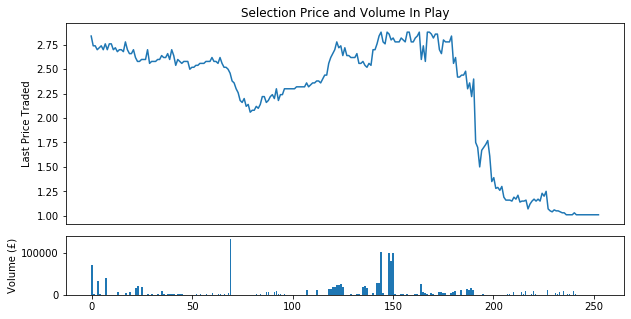

In [27]:
plt.figure(figsize=(10,5))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df_52106.TimeIndex, df_52106.LastPriceTraded) 
bottom.bar(df_52106.TimeIndex, df_52106.TradeSize) 

top.axes.get_xaxis().set_visible(False)
top.set_title('Selection Price and Volume In Play')
top.set_ylabel('Last Price Traded')
bottom.set_ylabel('Volume (£)')